In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_Rome_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_Rome_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_Rome_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [ ]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors',
    'latitude', 'longitude', 'date', 'id', 'host_id',
    "nearby_restaurants_bars", "nearby_transport",
    "mean_price_neighbors",
    "nearby_airbnbs_count",
    "neighbourhood_I Centro Storico",
    "neighbourhood_II Parioli/Nomentano",
    "neighbourhood_III Monte Sacro",
    "neighbourhood_IV Tiburtina", "neighbourhood_IX Eur",
    "neighbourhood_V Prenestino/Centocelle",
    "neighbourhood_VI Roma delle Torri",
    "neighbourhood_VII San Giovanni/Cinecittà",
    "neighbourhood_VIII Appia Antica",
    "neighbourhood_X Ostia/Acilia",
    "neighbourhood_XI Arvalia/Portuense",
    "neighbourhood_XII Monte Verde",
    "neighbourhood_XIII Aurelia",
    "neighbourhood_XIV Monte Mario",
    "neighbourhood_XV Cassia/Flaminia",
    "season_Autumn",
     "is_holiday", "is_school_holiday"])


    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


<ipython-input-11-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-11-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-11-471186034b60>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,total_amenities,listing_reviewed,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,luxury_amenities_score,kitchen_amenities
0,0.0,-0.442516,-0.333333,0.0,0.0,-0.25,0.0,-0.5,0.0,0.0,...,1.157895,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.333333
1,1.0,-0.373102,0.000000,0.0,5.0,2.50,0.0,0.0,0.0,0.0,...,-0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,1.0,0.433839,-0.333333,0.0,0.0,0.25,-1.0,-0.5,0.0,0.0,...,-0.894737,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-0.666667
3,0.0,-0.503254,-0.333333,0.0,0.0,-0.25,0.0,0.0,1.0,0.0,...,-0.631579,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.666667
4,0.0,-0.095445,-0.333333,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.368421,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_rome_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_rome_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_rome_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 15:06:30,127] A new study created in memory with name: no-name-0328b6b4-6311-45d4-8381-0df406fc7b07
Training PEGNN: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]
[I 2024-08-13 15:06:42,065] Trial 0 finished with value: 8.403142929077148 and parameters: {'hidden_channels': 73, 'lr': 0.002006777481055891, 'k': 15, 'dropout_rate': 0.39007531520810745}. Best is trial 0 with value: 8.403142929077148.
Training PEGNN: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]
[I 2024-08-13 15:07:19,792] Trial 1 finished with value: 9.515730857849121 and parameters: {'hidden_channels': 35, 'lr': 0.00021129507965077246, 'k': 48, 'dropout_rate': 0.14613472353000137}. Best is trial 0 with value: 8.403142929077148.
Training PEGNN: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]
[I 2024-08-13 15:07:32,970] Trial 2 finished with value: 9.32802677154541 and parameters: {'hidden_channels': 115, 'lr': 0.0003174225028219042, 'k': 13, 'dropout_rate': 0.36352335469339214}. Best is trial 0 with value:

Best parameters:  {'hidden_channels': 86, 'lr': 0.005339663867097429, 'k': 44, 'dropout_rate': 0.21778746151085793}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 6.306066513061523, Training R-squared: -0.03154052710849009, Training MAE: 1.002042531967163, Training MSE: 6.306066513061523
Epoch 1, Validation Loss: 10.16622543334961, Validation R-squared: -0.022836543213302418, Validation MAE: 1.6404379606246948, Validation MSE: 10.16622543334961


Final training:   0%|          | 2/500 [00:02<09:58,  1.20s/it]

Epoch 2, Training Loss: 6.514130115509033, Training R-squared: -0.06557541888715646, Training MAE: 1.5187323093414307, Training MSE: 6.514130115509033
Epoch 2, Validation Loss: 9.67866039276123, Validation R-squared: 0.026218119673108053, Validation MAE: 1.3114631175994873, Validation MSE: 9.67866039276123


Final training:   1%|          | 3/500 [00:03<08:48,  1.06s/it]

Epoch 3, Training Loss: 5.927578926086426, Training R-squared: 0.030372115091264584, Training MAE: 1.1878503561019897, Training MSE: 5.927578926086426
Epoch 3, Validation Loss: 9.60867977142334, Validation R-squared: 0.03325890483886618, Validation MAE: 1.0812610387802124, Validation MSE: 9.608680725097656


Final training:   1%|          | 4/500 [00:04<08:12,  1.01it/s]

Epoch 4, Training Loss: 5.772990703582764, Training R-squared: 0.05565944379451171, Training MAE: 0.9635946154594421, Training MSE: 5.772990703582764
Epoch 4, Validation Loss: 9.657682418823242, Validation R-squared: 0.02832864690263015, Validation MAE: 0.9915961623191833, Validation MSE: 9.657683372497559


Final training:   1%|          | 5/500 [00:05<07:54,  1.04it/s]

Epoch 5, Training Loss: 5.7881574630737305, Training R-squared: 0.05317853825253571, Training MAE: 0.8832191824913025, Training MSE: 5.7881574630737305
Epoch 5, Validation Loss: 9.595802307128906, Validation R-squared: 0.03455437191903421, Validation MAE: 0.9722433090209961, Validation MSE: 9.595803260803223


Final training:   1%|          | 6/500 [00:06<07:43,  1.07it/s]

Epoch 6, Training Loss: 5.732229232788086, Training R-squared: 0.06232710440215061, Training MAE: 0.8639822602272034, Training MSE: 5.732229709625244
Epoch 6, Validation Loss: 9.447251319885254, Validation R-squared: 0.04950044915607832, Validation MAE: 0.983597993850708, Validation MSE: 9.447251319885254


Final training:   1%|▏         | 7/500 [00:07<07:36,  1.08it/s]

Epoch 7, Training Loss: 5.616749286651611, Training R-squared: 0.0812173116258551, Training MAE: 0.869809091091156, Training MSE: 5.616749286651611
Epoch 7, Validation Loss: 9.29731273651123, Validation R-squared: 0.0645859038022717, Validation MAE: 1.0279598236083984, Validation MSE: 9.29731273651123


Final training:   2%|▏         | 8/500 [00:07<07:31,  1.09it/s]

Epoch 8, Training Loss: 5.50498104095459, Training R-squared: 0.09950022035450612, Training MAE: 0.9054964184761047, Training MSE: 5.50498104095459
Epoch 8, Validation Loss: 9.202435493469238, Validation R-squared: 0.0741315952116397, Validation MAE: 1.1008343696594238, Validation MSE: 9.202435493469238


Final training:   2%|▏         | 9/500 [00:08<07:27,  1.10it/s]

Epoch 9, Training Loss: 5.435234546661377, Training R-squared: 0.11090937690678582, Training MAE: 0.9688431024551392, Training MSE: 5.435234546661377
Epoch 9, Validation Loss: 9.163328170776367, Validation R-squared: 0.07806619385852331, Validation MAE: 1.1647322177886963, Validation MSE: 9.163329124450684


Final training:   2%|▏         | 10/500 [00:09<07:23,  1.10it/s]

Epoch 10, Training Loss: 5.422142505645752, Training R-squared: 0.113050951534448, Training MAE: 1.033161997795105, Training MSE: 5.422142028808594
Epoch 10, Validation Loss: 9.120325088500977, Validation R-squared: 0.082392835071595, Validation MAE: 1.1683226823806763, Validation MSE: 9.120325088500977


Final training:   2%|▏         | 11/500 [00:10<07:22,  1.11it/s]

Epoch 11, Training Loss: 5.394562721252441, Training R-squared: 0.11756250317427253, Training MAE: 1.0361301898956299, Training MSE: 5.394562244415283
Epoch 11, Validation Loss: 9.052359580993652, Validation R-squared: 0.08923103872460925, Validation MAE: 1.1084448099136353, Validation MSE: 9.052358627319336


Final training:   2%|▏         | 12/500 [00:11<07:23,  1.10it/s]

Epoch 12, Training Loss: 5.341111183166504, Training R-squared: 0.12630601844696931, Training MAE: 0.9827713370323181, Training MSE: 5.341110706329346
Epoch 12, Validation Loss: 9.00590991973877, Validation R-squared: 0.09390424776315098, Validation MAE: 1.0302660465240479, Validation MSE: 9.005910873413086


Final training:   3%|▎         | 13/500 [00:12<07:27,  1.09it/s]

Epoch 13, Training Loss: 5.244259834289551, Training R-squared: 0.1421488030891782, Training MAE: 0.9103243947029114, Training MSE: 5.244259834289551
Epoch 13, Validation Loss: 9.013882637023926, Validation R-squared: 0.09310201868606005, Validation MAE: 0.9882733225822449, Validation MSE: 9.013883590698242


Final training:   3%|▎         | 14/500 [00:13<07:30,  1.08it/s]

Epoch 14, Training Loss: 5.245809078216553, Training R-squared: 0.1418954243992243, Training MAE: 0.8807151913642883, Training MSE: 5.245809078216553
Epoch 14, Validation Loss: 9.007192611694336, Validation R-squared: 0.09377534935697707, Validation MAE: 0.9795344471931458, Validation MSE: 9.00719165802002


Final training:   3%|▎         | 15/500 [00:14<07:33,  1.07it/s]

Epoch 15, Training Loss: 5.250589370727539, Training R-squared: 0.14111350536172795, Training MAE: 0.8716686367988586, Training MSE: 5.250588417053223
Epoch 15, Validation Loss: 8.936319351196289, Validation R-squared: 0.1009059382070796, Validation MAE: 0.9848982095718384, Validation MSE: 8.936319351196289


Final training:   3%|▎         | 16/500 [00:15<07:29,  1.08it/s]

Epoch 16, Training Loss: 5.182684898376465, Training R-squared: 0.1522211387809791, Training MAE: 0.876574695110321, Training MSE: 5.182685375213623
Epoch 16, Validation Loss: 8.858449935913086, Validation R-squared: 0.10874038532231967, Validation MAE: 1.0135632753372192, Validation MSE: 8.858449935913086


Final training:   3%|▎         | 17/500 [00:16<07:25,  1.08it/s]

Epoch 17, Training Loss: 5.126561164855957, Training R-squared: 0.16140186218018338, Training MAE: 0.8972492814064026, Training MSE: 5.126560688018799
Epoch 17, Validation Loss: 8.818510055541992, Validation R-squared: 0.11275894433118738, Validation MAE: 1.058984637260437, Validation MSE: 8.818509101867676


Final training:   4%|▎         | 18/500 [00:17<07:22,  1.09it/s]

Epoch 18, Training Loss: 5.103063106536865, Training R-squared: 0.16524563696525152, Training MAE: 0.941230297088623, Training MSE: 5.103063106536865
Epoch 18, Validation Loss: 8.793777465820312, Validation R-squared: 0.11524727386349087, Validation MAE: 1.0831636190414429, Validation MSE: 8.793776512145996


Final training:   4%|▍         | 19/500 [00:17<07:18,  1.10it/s]

Epoch 19, Training Loss: 5.117834568023682, Training R-squared: 0.16282932861723864, Training MAE: 0.9597762227058411, Training MSE: 5.117834568023682
Epoch 19, Validation Loss: 8.755630493164062, Validation R-squared: 0.11908507624853304, Validation MAE: 1.0630977153778076, Validation MSE: 8.755632400512695


Final training:   4%|▍         | 20/500 [00:18<07:15,  1.10it/s]

Epoch 20, Training Loss: 5.052520275115967, Training R-squared: 0.17351339392910448, Training MAE: 0.9402688145637512, Training MSE: 5.052519798278809
Epoch 20, Validation Loss: 8.720524787902832, Validation R-squared: 0.12261722667873354, Validation MAE: 1.0162842273712158, Validation MSE: 8.720525741577148


Final training:   4%|▍         | 21/500 [00:19<07:14,  1.10it/s]

Epoch 21, Training Loss: 5.022079944610596, Training R-squared: 0.17849277710609157, Training MAE: 0.9030289649963379, Training MSE: 5.022079944610596
Epoch 21, Validation Loss: 8.709254264831543, Validation R-squared: 0.123751161178968, Validation MAE: 0.9733242392539978, Validation MSE: 8.709254264831543


Final training:   4%|▍         | 22/500 [00:20<07:13,  1.10it/s]

Epoch 22, Training Loss: 4.991842746734619, Training R-squared: 0.18343895045773928, Training MAE: 0.8645126819610596, Training MSE: 4.991842746734619
Epoch 22, Validation Loss: 8.702225685119629, Validation R-squared: 0.12445831692503884, Validation MAE: 0.9524093270301819, Validation MSE: 8.702225685119629


Final training:   5%|▍         | 23/500 [00:21<07:10,  1.11it/s]

Epoch 23, Training Loss: 4.946153163909912, Training R-squared: 0.19091276698179838, Training MAE: 0.8429253101348877, Training MSE: 4.94615364074707
Epoch 23, Validation Loss: 8.668747901916504, Validation R-squared: 0.12782659692517684, Validation MAE: 0.9512532949447632, Validation MSE: 8.668747901916504


Final training:   5%|▍         | 24/500 [00:22<07:10,  1.11it/s]

Epoch 24, Training Loss: 4.935171127319336, Training R-squared: 0.19270932501571725, Training MAE: 0.8439581990242004, Training MSE: 4.935170650482178
Epoch 24, Validation Loss: 8.613022804260254, Validation R-squared: 0.1334331996256649, Validation MAE: 0.9676671028137207, Validation MSE: 8.613022804260254


Final training:   5%|▌         | 25/500 [00:23<07:10,  1.10it/s]

Epoch 25, Training Loss: 4.936202049255371, Training R-squared: 0.19254062257733684, Training MAE: 0.8548988699913025, Training MSE: 4.936202049255371
Epoch 25, Validation Loss: 8.562002182006836, Validation R-squared: 0.13856654942578728, Validation MAE: 0.9959836602210999, Validation MSE: 8.562002182006836


Final training:   5%|▌         | 26/500 [00:24<07:09,  1.10it/s]

Epoch 26, Training Loss: 4.851423740386963, Training R-squared: 0.20640851641810487, Training MAE: 0.8777927160263062, Training MSE: 4.851424217224121
Epoch 26, Validation Loss: 8.52440357208252, Validation R-squared: 0.1423492134069293, Validation MAE: 1.0201408863067627, Validation MSE: 8.524404525756836


Final training:   5%|▌         | 27/500 [00:25<07:11,  1.10it/s]

Epoch 27, Training Loss: 4.863877773284912, Training R-squared: 0.20437135821686137, Training MAE: 0.9016333818435669, Training MSE: 4.863877773284912
Epoch 27, Validation Loss: 8.489607810974121, Validation R-squared: 0.14585011618423616, Validation MAE: 1.0178742408752441, Validation MSE: 8.489607810974121


Final training:   6%|▌         | 28/500 [00:26<07:15,  1.08it/s]

Epoch 28, Training Loss: 4.838893890380859, Training R-squared: 0.20845815771064213, Training MAE: 0.8991559147834778, Training MSE: 4.838893890380859
Epoch 28, Validation Loss: 8.456497192382812, Validation R-squared: 0.14918149478107734, Validation MAE: 0.9928174018859863, Validation MSE: 8.456497192382812


Final training:   6%|▌         | 29/500 [00:27<07:18,  1.07it/s]

Epoch 29, Training Loss: 4.820976734161377, Training R-squared: 0.2113890186486096, Training MAE: 0.8815751671791077, Training MSE: 4.820977210998535
Epoch 29, Validation Loss: 8.435371398925781, Validation R-squared: 0.15130690626629328, Validation MAE: 0.9650351405143738, Validation MSE: 8.435371398925781


Final training:   6%|▌         | 30/500 [00:28<07:19,  1.07it/s]

Epoch 30, Training Loss: 4.7609028816223145, Training R-squared: 0.22121587187986114, Training MAE: 0.8542457818984985, Training MSE: 4.7609028816223145
Epoch 30, Validation Loss: 8.416009902954102, Validation R-squared: 0.15325487521144698, Validation MAE: 0.9508334994316101, Validation MSE: 8.416009902954102


Final training:   6%|▌         | 31/500 [00:28<07:12,  1.09it/s]

Epoch 31, Training Loss: 4.782584190368652, Training R-squared: 0.21766925891108113, Training MAE: 0.8426139950752258, Training MSE: 4.782584190368652
Epoch 31, Validation Loss: 8.37816333770752, Validation R-squared: 0.1570626652275201, Validation MAE: 0.9492859840393066, Validation MSE: 8.378164291381836


Final training:   6%|▋         | 32/500 [00:29<07:09,  1.09it/s]

Epoch 32, Training Loss: 4.743842601776123, Training R-squared: 0.2240066119174129, Training MAE: 0.8440805077552795, Training MSE: 4.743842601776123
Epoch 32, Validation Loss: 8.326239585876465, Validation R-squared: 0.1622868028921267, Validation MAE: 0.9589630961418152, Validation MSE: 8.326239585876465


Final training:   7%|▋         | 33/500 [00:30<07:04,  1.10it/s]

Epoch 33, Training Loss: 4.6921586990356445, Training R-squared: 0.23246102142956004, Training MAE: 0.8537434935569763, Training MSE: 4.6921586990356445
Epoch 33, Validation Loss: 8.278579711914062, Validation R-squared: 0.1670817904056463, Validation MAE: 0.9737862348556519, Validation MSE: 8.278580665588379


Final training:   7%|▋         | 34/500 [00:31<07:09,  1.08it/s]

Epoch 34, Training Loss: 4.618010520935059, Training R-squared: 0.2445900527780802, Training MAE: 0.8646467924118042, Training MSE: 4.618010520935059
Epoch 34, Validation Loss: 8.239324569702148, Validation R-squared: 0.17103132102229202, Validation MAE: 0.985272228717804, Validation MSE: 8.239325523376465


Final training:   7%|▋         | 35/500 [00:32<07:05,  1.09it/s]

Epoch 35, Training Loss: 4.644669055938721, Training R-squared: 0.24022922981777461, Training MAE: 0.8721906542778015, Training MSE: 4.644669532775879
Epoch 35, Validation Loss: 8.203947067260742, Validation R-squared: 0.17459071580519214, Validation MAE: 0.9823659062385559, Validation MSE: 8.203947067260742


Final training:   7%|▋         | 36/500 [00:33<07:03,  1.09it/s]

Epoch 36, Training Loss: 4.587862968444824, Training R-squared: 0.24952161567242426, Training MAE: 0.8717215061187744, Training MSE: 4.587862968444824
Epoch 36, Validation Loss: 8.173468589782715, Validation R-squared: 0.17765725729171078, Validation MAE: 0.9674184918403625, Validation MSE: 8.173468589782715


Final training:   7%|▋         | 37/500 [00:34<06:58,  1.11it/s]

Epoch 37, Training Loss: 4.603266716003418, Training R-squared: 0.2470018633204527, Training MAE: 0.8554069995880127, Training MSE: 4.603266716003418
Epoch 37, Validation Loss: 8.148456573486328, Validation R-squared: 0.180173755425165, Validation MAE: 0.95313560962677, Validation MSE: 8.148456573486328


Final training:   8%|▊         | 38/500 [00:35<06:56,  1.11it/s]

Epoch 38, Training Loss: 4.548649311065674, Training R-squared: 0.25593608359032105, Training MAE: 0.8465934991836548, Training MSE: 4.548649787902832
Epoch 38, Validation Loss: 8.12072467803955, Validation R-squared: 0.1829638324525289, Validation MAE: 0.9469242095947266, Validation MSE: 8.12072467803955


Final training:   8%|▊         | 39/500 [00:36<06:54,  1.11it/s]

Epoch 39, Training Loss: 4.574277877807617, Training R-squared: 0.2517439111872819, Training MAE: 0.8380470275878906, Training MSE: 4.574277400970459
Epoch 39, Validation Loss: 8.082757949829102, Validation R-squared: 0.18678371977013675, Validation MAE: 0.950962483882904, Validation MSE: 8.082757949829102


Final training:   8%|▊         | 40/500 [00:37<06:53,  1.11it/s]

Epoch 40, Training Loss: 4.493786334991455, Training R-squared: 0.26491054791247637, Training MAE: 0.8440836668014526, Training MSE: 4.493786334991455
Epoch 40, Validation Loss: 8.038420677185059, Validation R-squared: 0.1912445767829597, Validation MAE: 0.9634196162223816, Validation MSE: 8.038420677185059


Final training:   8%|▊         | 41/500 [00:38<06:56,  1.10it/s]

Epoch 41, Training Loss: 4.487451553344727, Training R-squared: 0.2659468558745306, Training MAE: 0.8535190224647522, Training MSE: 4.487451076507568
Epoch 41, Validation Loss: 7.998148441314697, Validation R-squared: 0.19529641365214168, Validation MAE: 0.9741042256355286, Validation MSE: 7.9981489181518555


Final training:   8%|▊         | 42/500 [00:38<06:59,  1.09it/s]

Epoch 42, Training Loss: 4.449495792388916, Training R-squared: 0.27215560515116943, Training MAE: 0.8589468002319336, Training MSE: 4.449495315551758
Epoch 42, Validation Loss: 7.960914611816406, Validation R-squared: 0.19904253217011159, Validation MAE: 0.9766336679458618, Validation MSE: 7.9609150886535645


Final training:   9%|▊         | 43/500 [00:39<07:05,  1.07it/s]

Epoch 43, Training Loss: 4.439868450164795, Training R-squared: 0.27373035909629206, Training MAE: 0.8625840544700623, Training MSE: 4.439868450164795
Epoch 43, Validation Loss: 7.929828643798828, Validation R-squared: 0.20217016776499253, Validation MAE: 0.9681446552276611, Validation MSE: 7.929829120635986


Final training:   9%|▉         | 44/500 [00:40<07:03,  1.08it/s]

Epoch 44, Training Loss: 4.39288330078125, Training R-squared: 0.2814162244979288, Training MAE: 0.8490397334098816, Training MSE: 4.392882823944092
Epoch 44, Validation Loss: 7.90389347076416, Validation R-squared: 0.2047795579812537, Validation MAE: 0.9586504697799683, Validation MSE: 7.90389347076416


Final training:   9%|▉         | 45/500 [00:41<06:56,  1.09it/s]

Epoch 45, Training Loss: 4.408027172088623, Training R-squared: 0.27893897509798804, Training MAE: 0.8468697667121887, Training MSE: 4.408027172088623
Epoch 45, Validation Loss: 7.877027988433838, Validation R-squared: 0.20748247469703462, Validation MAE: 0.9538863301277161, Validation MSE: 7.877027988433838


Final training:   9%|▉         | 46/500 [00:42<06:52,  1.10it/s]

Epoch 46, Training Loss: 4.335650444030762, Training R-squared: 0.29077830958656714, Training MAE: 0.8370559215545654, Training MSE: 4.335650444030762
Epoch 46, Validation Loss: 7.843724250793457, Validation R-squared: 0.2108333013807615, Validation MAE: 0.9587891101837158, Validation MSE: 7.843723773956299


Final training:   9%|▉         | 47/500 [00:43<06:48,  1.11it/s]

Epoch 47, Training Loss: 4.3070268630981445, Training R-squared: 0.29546049852528644, Training MAE: 0.8429785966873169, Training MSE: 4.3070268630981445
Epoch 47, Validation Loss: 7.809295177459717, Validation R-squared: 0.21429720917813289, Validation MAE: 0.9662313461303711, Validation MSE: 7.809294700622559


Final training:  10%|▉         | 48/500 [00:44<06:45,  1.11it/s]

Epoch 48, Training Loss: 4.3157501220703125, Training R-squared: 0.2940335525667668, Training MAE: 0.8496865034103394, Training MSE: 4.3157501220703125
Epoch 48, Validation Loss: 7.776686668395996, Validation R-squared: 0.21757800919552783, Validation MAE: 0.968704104423523, Validation MSE: 7.77668571472168


Final training:  10%|▉         | 49/500 [00:45<06:43,  1.12it/s]

Epoch 49, Training Loss: 4.283928871154785, Training R-squared: 0.2992388948760505, Training MAE: 0.84987872838974, Training MSE: 4.283928871154785
Epoch 49, Validation Loss: 7.7487006187438965, Validation R-squared: 0.22039363563082104, Validation MAE: 0.9638388752937317, Validation MSE: 7.748701095581055


Final training:  10%|█         | 50/500 [00:46<06:42,  1.12it/s]

Epoch 50, Training Loss: 4.234918117523193, Training R-squared: 0.30725599383593916, Training MAE: 0.8451309204101562, Training MSE: 4.234918117523193
Epoch 50, Validation Loss: 7.720831394195557, Validation R-squared: 0.2231976503569606, Validation MAE: 0.958247721195221, Validation MSE: 7.720831394195557


Final training:  10%|█         | 51/500 [00:47<06:43,  1.11it/s]

Epoch 51, Training Loss: 4.283344268798828, Training R-squared: 0.29933450395031524, Training MAE: 0.8380045294761658, Training MSE: 4.283344268798828
Epoch 51, Validation Loss: 7.692017555236816, Validation R-squared: 0.22609659588299225, Validation MAE: 0.9547958970069885, Validation MSE: 7.692017555236816


Final training:  10%|█         | 52/500 [00:47<06:41,  1.12it/s]

Epoch 52, Training Loss: 4.186182498931885, Training R-squared: 0.3152281173400203, Training MAE: 0.8304938673973083, Training MSE: 4.186182498931885
Epoch 52, Validation Loss: 7.658880710601807, Validation R-squared: 0.22943055249474842, Validation MAE: 0.9541652798652649, Validation MSE: 7.658881187438965


Final training:  11%|█         | 53/500 [00:48<06:41,  1.11it/s]

Epoch 53, Training Loss: 4.1543097496032715, Training R-squared: 0.32044179151671337, Training MAE: 0.8277574777603149, Training MSE: 4.1543097496032715
Epoch 53, Validation Loss: 7.618993282318115, Validation R-squared: 0.23344373836515464, Validation MAE: 0.9584182500839233, Validation MSE: 7.618993282318115


Final training:  11%|█         | 54/500 [00:49<06:41,  1.11it/s]

Epoch 54, Training Loss: 4.116340637207031, Training R-squared: 0.32665279478670184, Training MAE: 0.834084153175354, Training MSE: 4.116340637207031
Epoch 54, Validation Loss: 7.582759857177734, Validation R-squared: 0.23708920595837557, Validation MAE: 0.9596235156059265, Validation MSE: 7.582759857177734


Final training:  11%|█         | 55/500 [00:50<06:46,  1.10it/s]

Epoch 55, Training Loss: 4.040346145629883, Training R-squared: 0.33908385788246176, Training MAE: 0.829452633857727, Training MSE: 4.040346145629883
Epoch 55, Validation Loss: 7.546170234680176, Validation R-squared: 0.2407705494601292, Validation MAE: 0.9595639109611511, Validation MSE: 7.546170234680176


Final training:  11%|█         | 56/500 [00:51<06:50,  1.08it/s]

Epoch 56, Training Loss: 4.091142654418945, Training R-squared: 0.33077464910425414, Training MAE: 0.8315434455871582, Training MSE: 4.091142654418945
Epoch 56, Validation Loss: 7.512495040893555, Validation R-squared: 0.2441586874968843, Validation MAE: 0.9551771879196167, Validation MSE: 7.512494087219238


Final training:  11%|█▏        | 57/500 [00:52<06:53,  1.07it/s]

Epoch 57, Training Loss: 3.968120813369751, Training R-squared: 0.35089840130360983, Training MAE: 0.8246296644210815, Training MSE: 3.96812105178833
Epoch 57, Validation Loss: 7.479213237762451, Validation R-squared: 0.24750711272505466, Validation MAE: 0.9509129524230957, Validation MSE: 7.479213237762451


Final training:  12%|█▏        | 58/500 [00:53<06:50,  1.08it/s]

Epoch 58, Training Loss: 3.9596760272979736, Training R-squared: 0.3522798377945646, Training MAE: 0.8192166090011597, Training MSE: 3.9596760272979736
Epoch 58, Validation Loss: 7.445036888122559, Validation R-squared: 0.25094570106210523, Validation MAE: 0.9493713974952698, Validation MSE: 7.445035457611084


Final training:  12%|█▏        | 59/500 [00:54<06:44,  1.09it/s]

Epoch 59, Training Loss: 3.951828718185425, Training R-squared: 0.3535634249438967, Training MAE: 0.8296909332275391, Training MSE: 3.951828718185425
Epoch 59, Validation Loss: 7.408075332641602, Validation R-squared: 0.254664409329847, Validation MAE: 0.9505560398101807, Validation MSE: 7.408075332641602


Final training:  12%|█▏        | 60/500 [00:55<06:42,  1.09it/s]

Epoch 60, Training Loss: 3.9766576290130615, Training R-squared: 0.3495020556351225, Training MAE: 0.8195849657058716, Training MSE: 3.976656913757324
Epoch 60, Validation Loss: 7.370604515075684, Validation R-squared: 0.2584343840010306, Validation MAE: 0.9513996839523315, Validation MSE: 7.370604515075684


Final training:  12%|█▏        | 61/500 [00:56<06:39,  1.10it/s]

Epoch 61, Training Loss: 3.85606050491333, Training R-squared: 0.3692291771539874, Training MAE: 0.821626603603363, Training MSE: 3.85606050491333
Epoch 61, Validation Loss: 7.3368048667907715, Validation R-squared: 0.26183493962891524, Validation MAE: 0.9492056965827942, Validation MSE: 7.336806297302246


Final training:  12%|█▏        | 62/500 [00:57<06:38,  1.10it/s]

Epoch 62, Training Loss: 3.8976216316223145, Training R-squared: 0.3624306486305353, Training MAE: 0.8195781111717224, Training MSE: 3.8976213932037354
Epoch 62, Validation Loss: 7.3050055503845215, Validation R-squared: 0.2650344490000224, Validation MAE: 0.9448843598365784, Validation MSE: 7.305005073547363


Final training:  13%|█▎        | 63/500 [00:58<06:38,  1.10it/s]

Epoch 63, Training Loss: 3.816352128982544, Training R-squared: 0.3757245988743618, Training MAE: 0.8175977468490601, Training MSE: 3.816352128982544
Epoch 63, Validation Loss: 7.273046493530273, Validation R-squared: 0.26824983267542835, Validation MAE: 0.9409170746803284, Validation MSE: 7.273046970367432


Final training:  13%|█▎        | 64/500 [00:58<06:34,  1.10it/s]

Epoch 64, Training Loss: 3.794219493865967, Training R-squared: 0.3793450826707234, Training MAE: 0.8072277903556824, Training MSE: 3.794219493865967
Epoch 64, Validation Loss: 7.237557411193848, Validation R-squared: 0.27182044131981886, Validation MAE: 0.9434300065040588, Validation MSE: 7.2375569343566895


Final training:  13%|█▎        | 65/500 [00:59<06:35,  1.10it/s]

Epoch 65, Training Loss: 3.817131519317627, Training R-squared: 0.375597102777259, Training MAE: 0.8146692514419556, Training MSE: 3.817131757736206
Epoch 65, Validation Loss: 7.202910900115967, Validation R-squared: 0.27530626451270546, Validation MAE: 0.9462558031082153, Validation MSE: 7.202910900115967


Final training:  13%|█▎        | 66/500 [01:00<06:32,  1.10it/s]

Epoch 66, Training Loss: 3.7640762329101562, Training R-squared: 0.38427588624824205, Training MAE: 0.8153713941574097, Training MSE: 3.7640762329101562
Epoch 66, Validation Loss: 7.165903091430664, Validation R-squared: 0.2790296864995956, Validation MAE: 0.947671115398407, Validation MSE: 7.165902614593506


Final training:  13%|█▎        | 67/500 [01:01<06:32,  1.10it/s]

Epoch 67, Training Loss: 3.7166240215301514, Training R-squared: 0.3920380877585464, Training MAE: 0.8095452189445496, Training MSE: 3.7166237831115723
Epoch 67, Validation Loss: 7.129854679107666, Validation R-squared: 0.2826565409002948, Validation MAE: 0.9468741416931152, Validation MSE: 7.129854202270508


Final training:  14%|█▎        | 68/500 [01:02<06:28,  1.11it/s]

Epoch 68, Training Loss: 3.7420051097869873, Training R-squared: 0.38788619909145994, Training MAE: 0.8154916763305664, Training MSE: 3.7420051097869873
Epoch 68, Validation Loss: 7.0975117683410645, Validation R-squared: 0.28591060425833503, Validation MAE: 0.9461948871612549, Validation MSE: 7.0975117683410645


Final training:  14%|█▍        | 69/500 [01:03<06:33,  1.10it/s]

Epoch 69, Training Loss: 3.6635046005249023, Training R-squared: 0.40072728206530495, Training MAE: 0.8125721216201782, Training MSE: 3.6635046005249023
Epoch 69, Validation Loss: 7.065079212188721, Validation R-squared: 0.289173682668283, Validation MAE: 0.9436249732971191, Validation MSE: 7.065079212188721


Final training:  14%|█▍        | 70/500 [01:04<06:39,  1.08it/s]

Epoch 70, Training Loss: 3.6106066703796387, Training R-squared: 0.4093802194360654, Training MAE: 0.802068829536438, Training MSE: 3.610607147216797
Epoch 70, Validation Loss: 7.029608726501465, Validation R-squared: 0.29274236988869595, Validation MAE: 0.9456595182418823, Validation MSE: 7.029609203338623


Final training:  14%|█▍        | 71/500 [01:05<06:42,  1.07it/s]

Epoch 71, Training Loss: 3.6155693531036377, Training R-squared: 0.4085685149963504, Training MAE: 0.8098821640014648, Training MSE: 3.6155691146850586
Epoch 71, Validation Loss: 6.99530553817749, Validation R-squared: 0.29619363433820656, Validation MAE: 0.9429226517677307, Validation MSE: 6.995306491851807


Final training:  14%|█▍        | 72/500 [01:06<06:38,  1.07it/s]

Epoch 72, Training Loss: 3.6131911277770996, Training R-squared: 0.40895752218940773, Training MAE: 0.8043006062507629, Training MSE: 3.6131906509399414
Epoch 72, Validation Loss: 6.9601149559021, Validation R-squared: 0.29973425572276646, Validation MAE: 0.9357208013534546, Validation MSE: 6.9601149559021


Final training:  15%|█▍        | 73/500 [01:07<06:32,  1.09it/s]

Epoch 73, Training Loss: 3.4909491539001465, Training R-squared: 0.42895376062305024, Training MAE: 0.7895077466964722, Training MSE: 3.4909491539001465
Epoch 73, Validation Loss: 6.916435718536377, Validation R-squared: 0.30412883438326954, Validation MAE: 0.9369691014289856, Validation MSE: 6.916436195373535


Final training:  15%|█▍        | 74/500 [01:08<06:30,  1.09it/s]

Epoch 74, Training Loss: 3.520839214324951, Training R-squared: 0.4240643284334913, Training MAE: 0.794291079044342, Training MSE: 3.520839214324951
Epoch 74, Validation Loss: 6.872005939483643, Validation R-squared: 0.30859895070154664, Validation MAE: 0.9465610980987549, Validation MSE: 6.872006893157959


Final training:  15%|█▌        | 75/500 [01:09<06:26,  1.10it/s]

Epoch 75, Training Loss: 3.3395979404449463, Training R-squared: 0.45371159714736764, Training MAE: 0.8002673983573914, Training MSE: 3.3395984172821045
Epoch 75, Validation Loss: 6.833820343017578, Validation R-squared: 0.3124409342599195, Validation MAE: 0.9493505954742432, Validation MSE: 6.833820343017578


Final training:  15%|█▌        | 76/500 [01:09<06:24,  1.10it/s]

Epoch 76, Training Loss: 3.407550811767578, Training R-squared: 0.4425959850744501, Training MAE: 0.8080256581306458, Training MSE: 3.407550811767578
Epoch 76, Validation Loss: 6.803863048553467, Validation R-squared: 0.31545493067905594, Validation MAE: 0.9420586824417114, Validation MSE: 6.803863048553467


Final training:  15%|█▌        | 77/500 [01:10<06:23,  1.10it/s]

Epoch 77, Training Loss: 3.420032501220703, Training R-squared: 0.4405542650537053, Training MAE: 0.8040006756782532, Training MSE: 3.420032501220703
Epoch 77, Validation Loss: 6.776307582855225, Validation R-squared: 0.31822739959145097, Validation MAE: 0.9311240911483765, Validation MSE: 6.776306629180908


Final training:  16%|█▌        | 78/500 [01:11<06:22,  1.10it/s]

Epoch 78, Training Loss: 3.400761127471924, Training R-squared: 0.44370664472839405, Training MAE: 0.7893146276473999, Training MSE: 3.400761127471924
Epoch 78, Validation Loss: 6.738391399383545, Validation R-squared: 0.3220421062944203, Validation MAE: 0.9313176274299622, Validation MSE: 6.738391399383545


Final training:  16%|█▌        | 79/500 [01:12<06:22,  1.10it/s]

Epoch 79, Training Loss: 3.361558675765991, Training R-squared: 0.4501193479011917, Training MAE: 0.7932235598564148, Training MSE: 3.361558675765991
Epoch 79, Validation Loss: 6.6979594230651855, Validation R-squared: 0.3261100213536393, Validation MAE: 0.9414428472518921, Validation MSE: 6.697959899902344


Final training:  16%|█▌        | 80/500 [01:13<06:20,  1.10it/s]

Epoch 80, Training Loss: 3.313483476638794, Training R-squared: 0.4579834618921752, Training MAE: 0.8012967705726624, Training MSE: 3.3134829998016357
Epoch 80, Validation Loss: 6.666669845581055, Validation R-squared: 0.32925819202437057, Validation MAE: 0.940281093120575, Validation MSE: 6.6666693687438965


Final training:  16%|█▌        | 81/500 [01:14<06:19,  1.10it/s]

Epoch 81, Training Loss: 3.381392478942871, Training R-squared: 0.4468749305774483, Training MAE: 0.7974314093589783, Training MSE: 3.381392478942871
Epoch 81, Validation Loss: 6.645950794219971, Validation R-squared: 0.3313427802344726, Validation MAE: 0.930550754070282, Validation MSE: 6.6459503173828125


Final training:  16%|█▋        | 82/500 [01:15<06:23,  1.09it/s]

Epoch 82, Training Loss: 3.2899398803710938, Training R-squared: 0.4618346629638589, Training MAE: 0.7837048172950745, Training MSE: 3.2899398803710938
Epoch 82, Validation Loss: 6.629014492034912, Validation R-squared: 0.3330466619743173, Validation MAE: 0.9231042861938477, Validation MSE: 6.62901496887207


Final training:  17%|█▋        | 83/500 [01:16<06:30,  1.07it/s]

Epoch 83, Training Loss: 3.2155861854553223, Training R-squared: 0.473997359839901, Training MAE: 0.7806460857391357, Training MSE: 3.2155861854553223
Epoch 83, Validation Loss: 6.594326972961426, Validation R-squared: 0.3365366209127144, Validation MAE: 0.9329280853271484, Validation MSE: 6.594326972961426


Final training:  17%|█▋        | 84/500 [01:17<06:36,  1.05it/s]

Epoch 84, Training Loss: 3.2970635890960693, Training R-squared: 0.4606694023459932, Training MAE: 0.7877975106239319, Training MSE: 3.2970635890960693
Epoch 84, Validation Loss: 6.563700199127197, Validation R-squared: 0.3396180720124111, Validation MAE: 0.9472202658653259, Validation MSE: 6.563699722290039


Final training:  17%|█▋        | 85/500 [01:18<06:32,  1.06it/s]

Epoch 85, Training Loss: 3.2956576347351074, Training R-squared: 0.4608993463722033, Training MAE: 0.7989287376403809, Training MSE: 3.2956576347351074
Epoch 85, Validation Loss: 6.540666580200195, Validation R-squared: 0.34193553896754514, Validation MAE: 0.9364557862281799, Validation MSE: 6.540666103363037


Final training:  17%|█▋        | 86/500 [01:19<06:26,  1.07it/s]

Epoch 86, Training Loss: 3.27673602104187, Training R-squared: 0.4639945564108131, Training MAE: 0.7856128811836243, Training MSE: 3.276735782623291
Epoch 86, Validation Loss: 6.519440174102783, Validation R-squared: 0.3440711203101535, Validation MAE: 0.9234116077423096, Validation MSE: 6.519440174102783


Final training:  17%|█▋        | 87/500 [01:20<06:19,  1.09it/s]

Epoch 87, Training Loss: 3.1507692337036133, Training R-squared: 0.4846000948548853, Training MAE: 0.7770024538040161, Training MSE: 3.1507692337036133
Epoch 87, Validation Loss: 6.492937088012695, Validation R-squared: 0.34673761720008645, Validation MAE: 0.9215604066848755, Validation MSE: 6.492937088012695


Final training:  18%|█▊        | 88/500 [01:21<06:15,  1.10it/s]

Epoch 88, Training Loss: 3.0184166431427, Training R-squared: 0.5062502196238021, Training MAE: 0.7704734802246094, Training MSE: 3.018416404724121
Epoch 88, Validation Loss: 6.457948207855225, Validation R-squared: 0.3502579186253969, Validation MAE: 0.9334679841995239, Validation MSE: 6.457947731018066


Final training:  18%|█▊        | 89/500 [01:21<06:13,  1.10it/s]

Epoch 89, Training Loss: 3.1445391178131104, Training R-squared: 0.4856192229339771, Training MAE: 0.774854302406311, Training MSE: 3.1445391178131104
Epoch 89, Validation Loss: 6.431231498718262, Validation R-squared: 0.35294589176663027, Validation MAE: 0.9446018934249878, Validation MSE: 6.431231498718262


Final training:  18%|█▊        | 90/500 [01:22<06:11,  1.10it/s]

Epoch 90, Training Loss: 3.119063138961792, Training R-squared: 0.48978649291098353, Training MAE: 0.7925935983657837, Training MSE: 3.119063138961792
Epoch 90, Validation Loss: 6.405615329742432, Validation R-squared: 0.35552320760015876, Validation MAE: 0.9376358389854431, Validation MSE: 6.40561580657959


Final training:  18%|█▊        | 91/500 [01:23<06:12,  1.10it/s]

Epoch 91, Training Loss: 2.955106019973755, Training R-squared: 0.5166065282684762, Training MAE: 0.7778043746948242, Training MSE: 2.9551055431365967
Epoch 91, Validation Loss: 6.383094787597656, Validation R-squared: 0.3577889891221667, Validation MAE: 0.9260653853416443, Validation MSE: 6.383094787597656


Final training:  18%|█▊        | 92/500 [01:24<06:11,  1.10it/s]

Epoch 92, Training Loss: 2.9793436527252197, Training R-squared: 0.5126417154980891, Training MAE: 0.7713698148727417, Training MSE: 2.9793436527252197
Epoch 92, Validation Loss: 6.358741283416748, Validation R-squared: 0.36023923818993975, Validation MAE: 0.9249144196510315, Validation MSE: 6.35874080657959


Final training:  19%|█▊        | 93/500 [01:25<06:09,  1.10it/s]

Epoch 93, Training Loss: 2.970151662826538, Training R-squared: 0.5141453202751636, Training MAE: 0.7745035886764526, Training MSE: 2.970151662826538
Epoch 93, Validation Loss: 6.333022594451904, Validation R-squared: 0.36282682620290585, Validation MAE: 0.9305700659751892, Validation MSE: 6.333022117614746


Final training:  19%|█▉        | 94/500 [01:26<06:07,  1.11it/s]

Epoch 94, Training Loss: 2.9808526039123535, Training R-squared: 0.5123949198002355, Training MAE: 0.7714194059371948, Training MSE: 2.9808521270751953
Epoch 94, Validation Loss: 6.314201354980469, Validation R-squared: 0.36472036243413275, Validation MAE: 0.9329073429107666, Validation MSE: 6.314202308654785


Final training:  19%|█▉        | 95/500 [01:27<06:04,  1.11it/s]

Epoch 95, Training Loss: 2.8696982860565186, Training R-squared: 0.5305774262970184, Training MAE: 0.7781690955162048, Training MSE: 2.8696982860565186
Epoch 95, Validation Loss: 6.298710823059082, Validation R-squared: 0.3662789621452003, Validation MAE: 0.9243090748786926, Validation MSE: 6.298710346221924


Final training:  19%|█▉        | 96/500 [01:28<06:09,  1.09it/s]

Epoch 96, Training Loss: 2.8364317417144775, Training R-squared: 0.5360190929399444, Training MAE: 0.7680032849311829, Training MSE: 2.8364319801330566
Epoch 96, Validation Loss: 6.28288459777832, Validation R-squared: 0.3678712501041803, Validation MAE: 0.9214860796928406, Validation MSE: 6.2828850746154785


Final training:  19%|█▉        | 97/500 [01:29<06:14,  1.08it/s]

Epoch 97, Training Loss: 2.825281858444214, Training R-squared: 0.5378429906491102, Training MAE: 0.7620129585266113, Training MSE: 2.825281858444214
Epoch 97, Validation Loss: 6.258870601654053, Validation R-squared: 0.37028731704418305, Validation MAE: 0.9271702170372009, Validation MSE: 6.258871078491211


Final training:  20%|█▉        | 98/500 [01:30<06:16,  1.07it/s]

Epoch 98, Training Loss: 2.7539193630218506, Training R-squared: 0.5495163934088583, Training MAE: 0.764761745929718, Training MSE: 2.7539193630218506
Epoch 98, Validation Loss: 6.236424922943115, Validation R-squared: 0.3725456776267756, Validation MAE: 0.9337479472160339, Validation MSE: 6.236423969268799


Final training:  20%|█▉        | 99/500 [01:31<06:13,  1.07it/s]

Epoch 99, Training Loss: 2.767521858215332, Training R-squared: 0.5472913286550425, Training MAE: 0.7713434100151062, Training MSE: 2.767521858215332
Epoch 99, Validation Loss: 6.217265605926514, Validation R-squared: 0.37447322823670637, Validation MAE: 0.9284594655036926, Validation MSE: 6.217265605926514


Final training:  20%|██        | 100/500 [01:32<06:07,  1.09it/s]

Epoch 100, Training Loss: 2.6938490867614746, Training R-squared: 0.5593426695277158, Training MAE: 0.7642018795013428, Training MSE: 2.6938488483428955
Epoch 100, Validation Loss: 6.200527191162109, Validation R-squared: 0.37615729703723066, Validation MAE: 0.9226195216178894, Validation MSE: 6.200527191162109


Final training:  20%|██        | 101/500 [01:32<06:09,  1.08it/s]

Epoch 101, Training Loss: 2.795811891555786, Training R-squared: 0.5426636653173409, Training MAE: 0.7592857480049133, Training MSE: 2.795811891555786
Epoch 101, Validation Loss: 6.182045936584473, Validation R-squared: 0.37801676220023483, Validation MAE: 0.9204561710357666, Validation MSE: 6.182045936584473


Final training:  20%|██        | 102/500 [01:33<06:04,  1.09it/s]

Epoch 102, Training Loss: 2.8052380084991455, Training R-squared: 0.5411217679636562, Training MAE: 0.7587746381759644, Training MSE: 2.8052380084991455
Epoch 102, Validation Loss: 6.1587114334106445, Validation R-squared: 0.3803645099632964, Validation MAE: 0.9266359806060791, Validation MSE: 6.158710956573486


Final training:  21%|██        | 103/500 [01:34<06:00,  1.10it/s]

Epoch 103, Training Loss: 2.69918155670166, Training R-squared: 0.5584703325792872, Training MAE: 0.7625097036361694, Training MSE: 2.69918155670166
Epoch 103, Validation Loss: 6.141369342803955, Validation R-squared: 0.38210932372394746, Validation MAE: 0.9277173280715942, Validation MSE: 6.141368389129639


Final training:  21%|██        | 104/500 [01:35<05:58,  1.11it/s]

Epoch 104, Training Loss: 2.669903516769409, Training R-squared: 0.5632596672443586, Training MAE: 0.7551236748695374, Training MSE: 2.669903516769409
Epoch 104, Validation Loss: 6.1258978843688965, Validation R-squared: 0.3836658451384771, Validation MAE: 0.924728512763977, Validation MSE: 6.125898361206055


Final training:  21%|██        | 105/500 [01:36<05:56,  1.11it/s]

Epoch 105, Training Loss: 2.7347450256347656, Training R-squared: 0.5526528716725746, Training MAE: 0.7612630128860474, Training MSE: 2.734745502471924
Epoch 105, Validation Loss: 6.113627910614014, Validation R-squared: 0.38490032884137815, Validation MAE: 0.9253983497619629, Validation MSE: 6.113627910614014


Final training:  21%|██        | 106/500 [01:37<05:54,  1.11it/s]

Epoch 106, Training Loss: 2.550140380859375, Training R-squared: 0.582850360083145, Training MAE: 0.7568382024765015, Training MSE: 2.550140619277954
Epoch 106, Validation Loss: 6.099710464477539, Validation R-squared: 0.38630060410944, Validation MAE: 0.9232715368270874, Validation MSE: 6.099710941314697


Final training:  21%|██▏       | 107/500 [01:38<05:53,  1.11it/s]

Epoch 107, Training Loss: 2.597189426422119, Training R-squared: 0.5751541635007116, Training MAE: 0.7587628364562988, Training MSE: 2.59718918800354
Epoch 107, Validation Loss: 6.082650184631348, Validation R-squared: 0.3880170927825374, Validation MAE: 0.9227608442306519, Validation MSE: 6.082650184631348


Final training:  22%|██▏       | 108/500 [01:39<05:54,  1.11it/s]

Epoch 108, Training Loss: 2.6244852542877197, Training R-squared: 0.5706891297449813, Training MAE: 0.754406750202179, Training MSE: 2.6244852542877197
Epoch 108, Validation Loss: 6.064958572387695, Validation R-squared: 0.38979702798294047, Validation MAE: 0.9287933707237244, Validation MSE: 6.0649590492248535


Final training:  22%|██▏       | 109/500 [01:40<05:54,  1.10it/s]

Epoch 109, Training Loss: 2.6312918663024902, Training R-squared: 0.5695757143146118, Training MAE: 0.7615320086479187, Training MSE: 2.631291627883911
Epoch 109, Validation Loss: 6.043536186218262, Validation R-squared: 0.3919523528793125, Validation MAE: 0.9258689284324646, Validation MSE: 6.04353666305542


Final training:  22%|██▏       | 110/500 [01:41<06:00,  1.08it/s]

Epoch 110, Training Loss: 2.586212635040283, Training R-squared: 0.5769496918770651, Training MAE: 0.7573336362838745, Training MSE: 2.5862128734588623
Epoch 110, Validation Loss: 6.030026912689209, Validation R-squared: 0.3933115206235632, Validation MAE: 0.9149491190910339, Validation MSE: 6.030027389526367


Final training:  22%|██▏       | 111/500 [01:42<06:06,  1.06it/s]

Epoch 111, Training Loss: 2.4339816570281982, Training R-squared: 0.6018515212902522, Training MAE: 0.7481788992881775, Training MSE: 2.4339816570281982
Epoch 111, Validation Loss: 6.020925521850586, Validation R-squared: 0.39422727572113203, Validation MAE: 0.9035853147506714, Validation MSE: 6.020925998687744


Final training:  22%|██▏       | 112/500 [01:43<06:05,  1.06it/s]

Epoch 112, Training Loss: 2.5118014812469482, Training R-squared: 0.5891218223108357, Training MAE: 0.7365288138389587, Training MSE: 2.5118014812469482
Epoch 112, Validation Loss: 5.998509883880615, Validation R-squared: 0.3964825674965564, Validation MAE: 0.9149488806724548, Validation MSE: 5.998509407043457


Final training:  23%|██▎       | 113/500 [01:43<06:02,  1.07it/s]

Epoch 113, Training Loss: 2.410968065261841, Training R-squared: 0.6056160681021587, Training MAE: 0.7382686138153076, Training MSE: 2.4109678268432617
Epoch 113, Validation Loss: 5.984891414642334, Validation R-squared: 0.3978526732039189, Validation MAE: 0.9286544322967529, Validation MSE: 5.984891414642334


Final training:  23%|██▎       | 114/500 [01:44<05:58,  1.08it/s]

Epoch 114, Training Loss: 2.4713892936706543, Training R-squared: 0.5957324174141447, Training MAE: 0.7515325546264648, Training MSE: 2.4713892936706543
Epoch 114, Validation Loss: 5.976883888244629, Validation R-squared: 0.3986583506934328, Validation MAE: 0.9180917739868164, Validation MSE: 5.976883888244629


Final training:  23%|██▎       | 115/500 [01:45<05:52,  1.09it/s]

Epoch 115, Training Loss: 2.4161884784698486, Training R-squared: 0.6047621645247803, Training MAE: 0.7381576895713806, Training MSE: 2.4161882400512695
Epoch 115, Validation Loss: 5.975383281707764, Validation R-squared: 0.3988093399253102, Validation MAE: 0.9081588387489319, Validation MSE: 5.975383281707764


Final training:  23%|██▎       | 116/500 [01:46<05:51,  1.09it/s]

Epoch 116, Training Loss: 2.455620050430298, Training R-squared: 0.5983118972183805, Training MAE: 0.7286229133605957, Training MSE: 2.455620527267456
Epoch 116, Validation Loss: 5.964578628540039, Validation R-squared: 0.3998963706920893, Validation MAE: 0.9160317182540894, Validation MSE: 5.964579105377197


Final training:  23%|██▎       | 117/500 [01:47<05:47,  1.10it/s]

Epoch 117, Training Loss: 2.3964638710021973, Training R-squared: 0.607988632423168, Training MAE: 0.7326157093048096, Training MSE: 2.3964638710021973
Epoch 117, Validation Loss: 5.954507827758789, Validation R-squared: 0.40090959465019227, Validation MAE: 0.9344797730445862, Validation MSE: 5.954508304595947


Final training:  24%|██▎       | 118/500 [01:48<05:45,  1.10it/s]

Epoch 118, Training Loss: 2.3743836879730225, Training R-squared: 0.6116005072380399, Training MAE: 0.745204746723175, Training MSE: 2.3743836879730225
Epoch 118, Validation Loss: 5.9353461265563965, Validation R-squared: 0.4028374816598973, Validation MAE: 0.9243994355201721, Validation MSE: 5.9353461265563965


Final training:  24%|██▍       | 119/500 [01:49<05:45,  1.10it/s]

Epoch 119, Training Loss: 2.453383684158325, Training R-squared: 0.598677797116551, Training MAE: 0.7385107278823853, Training MSE: 2.453383445739746
Epoch 119, Validation Loss: 5.923773765563965, Validation R-squared: 0.4040018049121713, Validation MAE: 0.9117034077644348, Validation MSE: 5.923773765563965


Final training:  24%|██▍       | 120/500 [01:50<05:43,  1.11it/s]

Epoch 120, Training Loss: 2.3482320308685303, Training R-squared: 0.6158783783751822, Training MAE: 0.7266280651092529, Training MSE: 2.348231792449951
Epoch 120, Validation Loss: 5.905527114868164, Validation R-squared: 0.4058376629517165, Validation MAE: 0.915165901184082, Validation MSE: 5.905526638031006


Final training:  24%|██▍       | 121/500 [01:51<05:42,  1.11it/s]

Epoch 121, Training Loss: 2.2732653617858887, Training R-squared: 0.6281413192213444, Training MAE: 0.7291414141654968, Training MSE: 2.2732653617858887
Epoch 121, Validation Loss: 5.892308712005615, Validation R-squared: 0.40716758596160607, Validation MAE: 0.927801251411438, Validation MSE: 5.892308712005615


Final training:  24%|██▍       | 122/500 [01:52<05:41,  1.11it/s]

Epoch 122, Training Loss: 2.4811878204345703, Training R-squared: 0.5941295764806176, Training MAE: 0.737375020980835, Training MSE: 2.4811880588531494
Epoch 122, Validation Loss: 5.885699272155762, Validation R-squared: 0.40783259825930473, Validation MAE: 0.9264123439788818, Validation MSE: 5.8856987953186035


Final training:  25%|██▍       | 123/500 [01:52<05:41,  1.10it/s]

Epoch 123, Training Loss: 2.2272913455963135, Training R-squared: 0.6356617466283183, Training MAE: 0.7332531809806824, Training MSE: 2.2272913455963135
Epoch 123, Validation Loss: 5.885376930236816, Validation R-squared: 0.40786501219413773, Validation MAE: 0.9139047861099243, Validation MSE: 5.885376930236816


Final training:  25%|██▍       | 124/500 [01:53<05:46,  1.09it/s]

Epoch 124, Training Loss: 2.318835973739624, Training R-squared: 0.6206869773090669, Training MAE: 0.73013836145401, Training MSE: 2.318835735321045
Epoch 124, Validation Loss: 5.881237983703613, Validation R-squared: 0.4082814416706432, Validation MAE: 0.9159077405929565, Validation MSE: 5.881237506866455


Final training:  25%|██▌       | 125/500 [01:54<05:50,  1.07it/s]

Epoch 125, Training Loss: 2.1845335960388184, Training R-squared: 0.6426559842689259, Training MAE: 0.7219653129577637, Training MSE: 2.1845338344573975
Epoch 125, Validation Loss: 5.880903720855713, Validation R-squared: 0.40831505550316305, Validation MAE: 0.9225899577140808, Validation MSE: 5.880903244018555


Final training:  25%|██▌       | 126/500 [01:55<05:48,  1.07it/s]

Epoch 126, Training Loss: 2.148084878921509, Training R-squared: 0.6486182665512383, Training MAE: 0.730209469795227, Training MSE: 2.148084878921509
Epoch 126, Validation Loss: 5.885574817657471, Validation R-squared: 0.4078450895421707, Validation MAE: 0.9260009527206421, Validation MSE: 5.8855743408203125


Final training:  25%|██▌       | 127/500 [01:56<05:43,  1.09it/s]

Epoch 127, Training Loss: 2.3117477893829346, Training R-squared: 0.6218464451892989, Training MAE: 0.7246212363243103, Training MSE: 2.3117477893829346
Epoch 127, Validation Loss: 5.8868231773376465, Validation R-squared: 0.4077195370100546, Validation MAE: 0.9213012456893921, Validation MSE: 5.88682222366333


Final training:  26%|██▌       | 128/500 [01:57<05:40,  1.09it/s]

Epoch 128, Training Loss: 2.2187511920928955, Training R-squared: 0.6370586828651803, Training MAE: 0.7254478931427002, Training MSE: 2.2187514305114746
Epoch 128, Validation Loss: 5.872004985809326, Validation R-squared: 0.4092103841747493, Validation MAE: 0.9112793803215027, Validation MSE: 5.872004985809326


Final training:  26%|██▌       | 129/500 [01:58<05:41,  1.09it/s]

Epoch 129, Training Loss: 2.215146541595459, Training R-squared: 0.6376483687798584, Training MAE: 0.712947428226471, Training MSE: 2.215146541595459
Epoch 129, Validation Loss: 5.85499906539917, Validation R-squared: 0.41092135674688746, Validation MAE: 0.9168872237205505, Validation MSE: 5.85499906539917


Final training:  26%|██▌       | 130/500 [01:59<05:40,  1.09it/s]

Epoch 130, Training Loss: 2.0726966857910156, Training R-squared: 0.6609502020451621, Training MAE: 0.7126625776290894, Training MSE: 2.0726966857910156
Epoch 130, Validation Loss: 5.841875076293945, Validation R-squared: 0.412241768632014, Validation MAE: 0.9281998872756958, Validation MSE: 5.841874599456787


Final training:  26%|██▌       | 131/500 [02:00<05:39,  1.09it/s]

Epoch 131, Training Loss: 2.050114631652832, Training R-squared: 0.6646441660251805, Training MAE: 0.7111296653747559, Training MSE: 2.050114393234253
Epoch 131, Validation Loss: 5.833960056304932, Validation R-squared: 0.413038092687235, Validation MAE: 0.9158660173416138, Validation MSE: 5.833960056304932


Final training:  26%|██▋       | 132/500 [02:01<05:36,  1.09it/s]

Epoch 132, Training Loss: 2.127831220626831, Training R-squared: 0.6519313331636114, Training MAE: 0.7105461955070496, Training MSE: 2.127831220626831
Epoch 132, Validation Loss: 5.831863880157471, Validation R-squared: 0.4132489710993741, Validation MAE: 0.9076427221298218, Validation MSE: 5.831864356994629


Final training:  27%|██▋       | 133/500 [02:02<05:34,  1.10it/s]

Epoch 133, Training Loss: 2.1535775661468506, Training R-squared: 0.6477197742885559, Training MAE: 0.7034008502960205, Training MSE: 2.1535775661468506
Epoch 133, Validation Loss: 5.824396133422852, Validation R-squared: 0.41400039079397477, Validation MAE: 0.9143756628036499, Validation MSE: 5.824395656585693


Final training:  27%|██▋       | 134/500 [02:03<05:33,  1.10it/s]

Epoch 134, Training Loss: 2.0486817359924316, Training R-squared: 0.6648785510769197, Training MAE: 0.7105908393859863, Training MSE: 2.0486817359924316
Epoch 134, Validation Loss: 5.819647789001465, Validation R-squared: 0.41447807534830816, Validation MAE: 0.9229859113693237, Validation MSE: 5.819647312164307


Final training:  27%|██▋       | 135/500 [02:04<05:31,  1.10it/s]

Epoch 135, Training Loss: 2.0670061111450195, Training R-squared: 0.6618810258551799, Training MAE: 0.7184662222862244, Training MSE: 2.0670061111450195
Epoch 135, Validation Loss: 5.814744472503662, Validation R-squared: 0.4149713533857322, Validation MAE: 0.9155228137969971, Validation MSE: 5.81474494934082


Final training:  27%|██▋       | 136/500 [02:04<05:30,  1.10it/s]

Epoch 136, Training Loss: 1.9723703861236572, Training R-squared: 0.6773614747892633, Training MAE: 0.7074533104896545, Training MSE: 1.9723703861236572
Epoch 136, Validation Loss: 5.813796520233154, Validation R-squared: 0.4150668059593874, Validation MAE: 0.9095804691314697, Validation MSE: 5.813796043395996


Final training:  27%|██▋       | 137/500 [02:05<05:32,  1.09it/s]

Epoch 137, Training Loss: 1.9108757972717285, Training R-squared: 0.6874207067437759, Training MAE: 0.6978590488433838, Training MSE: 1.9108757972717285
Epoch 137, Validation Loss: 5.810238361358643, Validation R-squared: 0.4154248166733683, Validation MAE: 0.9101278185844421, Validation MSE: 5.810237884521484


Final training:  28%|██▊       | 138/500 [02:06<05:35,  1.08it/s]

Epoch 138, Training Loss: 1.938990592956543, Training R-squared: 0.682821708034711, Training MAE: 0.6970674395561218, Training MSE: 1.938990592956543
Epoch 138, Validation Loss: 5.807311534881592, Validation R-squared: 0.41571921391926303, Validation MAE: 0.9230726957321167, Validation MSE: 5.807311534881592


Final training:  28%|██▊       | 139/500 [02:07<05:39,  1.06it/s]

Epoch 139, Training Loss: 1.9941807985305786, Training R-squared: 0.6737937173787361, Training MAE: 0.7032086849212646, Training MSE: 1.9941810369491577
Epoch 139, Validation Loss: 5.805144309997559, Validation R-squared: 0.4159372865979277, Validation MAE: 0.9285025596618652, Validation MSE: 5.805144309997559


Final training:  28%|██▊       | 140/500 [02:08<05:37,  1.07it/s]

Epoch 140, Training Loss: 2.0454869270324707, Training R-squared: 0.6654011465811185, Training MAE: 0.7136430740356445, Training MSE: 2.0454866886138916
Epoch 140, Validation Loss: 5.80933141708374, Validation R-squared: 0.41551602976998525, Validation MAE: 0.9236254096031189, Validation MSE: 5.809330940246582


Final training:  28%|██▊       | 141/500 [02:09<05:32,  1.08it/s]

Epoch 141, Training Loss: 1.9529263973236084, Training R-squared: 0.6805420748332045, Training MAE: 0.7076725959777832, Training MSE: 1.9529263973236084
Epoch 141, Validation Loss: 5.811089992523193, Validation R-squared: 0.4153390711936402, Validation MAE: 0.9148117899894714, Validation MSE: 5.811089992523193


Final training:  28%|██▊       | 142/500 [02:10<05:27,  1.09it/s]

Epoch 142, Training Loss: 1.9349555969238281, Training R-squared: 0.6834817545831091, Training MAE: 0.6911895871162415, Training MSE: 1.9349555969238281
Epoch 142, Validation Loss: 5.804203987121582, Validation R-squared: 0.4160319645523003, Validation MAE: 0.9184741377830505, Validation MSE: 5.804203033447266


Final training:  29%|██▊       | 143/500 [02:11<05:25,  1.10it/s]

Epoch 143, Training Loss: 2.050463914871216, Training R-squared: 0.6645869504512161, Training MAE: 0.6997427344322205, Training MSE: 2.050464153289795
Epoch 143, Validation Loss: 5.784287929534912, Validation R-squared: 0.41803560475639556, Validation MAE: 0.9269360303878784, Validation MSE: 5.78428840637207


Final training:  29%|██▉       | 144/500 [02:12<05:22,  1.11it/s]

Epoch 144, Training Loss: 1.8786571025848389, Training R-squared: 0.6926909756466785, Training MAE: 0.7008528113365173, Training MSE: 1.8786572217941284
Epoch 144, Validation Loss: 5.760514736175537, Validation R-squared: 0.420427556447171, Validation MAE: 0.9135329127311707, Validation MSE: 5.760514259338379


Final training:  29%|██▉       | 145/500 [02:13<05:22,  1.10it/s]

Epoch 145, Training Loss: 1.8808554410934448, Training R-squared: 0.6923313917147903, Training MAE: 0.6917921304702759, Training MSE: 1.8808554410934448
Epoch 145, Validation Loss: 5.74231481552124, Validation R-squared: 0.4222586549080416, Validation MAE: 0.9125289916992188, Validation MSE: 5.742314338684082


Final training:  29%|██▉       | 146/500 [02:14<05:21,  1.10it/s]

Epoch 146, Training Loss: 1.8982079029083252, Training R-squared: 0.6894929265202419, Training MAE: 0.686749279499054, Training MSE: 1.898207664489746
Epoch 146, Validation Loss: 5.7363386154174805, Validation R-squared: 0.4228599521808183, Validation MAE: 0.921322226524353, Validation MSE: 5.736337661743164


Final training:  29%|██▉       | 147/500 [02:15<05:19,  1.10it/s]

Epoch 147, Training Loss: 1.785662055015564, Training R-squared: 0.7079030471275629, Training MAE: 0.700027585029602, Training MSE: 1.785662055015564
Epoch 147, Validation Loss: 5.73298454284668, Validation R-squared: 0.42319741515560105, Validation MAE: 0.9135828614234924, Validation MSE: 5.7329840660095215


Final training:  30%|██▉       | 148/500 [02:15<05:18,  1.10it/s]

Epoch 148, Training Loss: 1.8408184051513672, Training R-squared: 0.6988806468569648, Training MAE: 0.6960201859474182, Training MSE: 1.8408184051513672
Epoch 148, Validation Loss: 5.732301712036133, Validation R-squared: 0.42326609540377225, Validation MAE: 0.9125908613204956, Validation MSE: 5.732301712036133


Final training:  30%|██▉       | 149/500 [02:16<05:16,  1.11it/s]

Epoch 149, Training Loss: 1.7979544401168823, Training R-squared: 0.7058922617712043, Training MAE: 0.6875160932540894, Training MSE: 1.7979544401168823
Epoch 149, Validation Loss: 5.732844829559326, Validation R-squared: 0.4232114338079961, Validation MAE: 0.9119340777397156, Validation MSE: 5.732845306396484


Final training:  30%|███       | 150/500 [02:17<05:14,  1.11it/s]

Epoch 150, Training Loss: 1.9080008268356323, Training R-squared: 0.6878909743015664, Training MAE: 0.6855610609054565, Training MSE: 1.9080009460449219
Epoch 150, Validation Loss: 5.729743003845215, Validation R-squared: 0.4235234693350861, Validation MAE: 0.9182533025741577, Validation MSE: 5.729743003845215


Final training:  30%|███       | 151/500 [02:18<05:15,  1.11it/s]

Epoch 151, Training Loss: 1.8410561084747314, Training R-squared: 0.6988417143757335, Training MAE: 0.6807199716567993, Training MSE: 1.8410563468933105
Epoch 151, Validation Loss: 5.729562282562256, Validation R-squared: 0.4235416135124883, Validation MAE: 0.9188787937164307, Validation MSE: 5.729562759399414


Final training:  30%|███       | 152/500 [02:19<05:16,  1.10it/s]

Epoch 152, Training Loss: 1.8001482486724854, Training R-squared: 0.7055334073004111, Training MAE: 0.6806918978691101, Training MSE: 1.8001482486724854
Epoch 152, Validation Loss: 5.730811595916748, Validation R-squared: 0.4234160324356637, Validation MAE: 0.9193955063819885, Validation MSE: 5.73081111907959


Final training:  31%|███       | 153/500 [02:20<05:20,  1.08it/s]

Epoch 153, Training Loss: 1.9071745872497559, Training R-squared: 0.6880261519401027, Training MAE: 0.693041980266571, Training MSE: 1.9071744680404663
Epoch 153, Validation Loss: 5.730220317840576, Validation R-squared: 0.4234754462420697, Validation MAE: 0.9257897138595581, Validation MSE: 5.730220794677734


Final training:  31%|███       | 154/500 [02:21<05:21,  1.08it/s]

Epoch 154, Training Loss: 1.7462892532348633, Training R-squared: 0.7143436108882544, Training MAE: 0.682765781879425, Training MSE: 1.7462893724441528
Epoch 154, Validation Loss: 5.722018718719482, Validation R-squared: 0.42430062933023704, Validation MAE: 0.9232908487319946, Validation MSE: 5.722019195556641


Final training:  31%|███       | 155/500 [02:22<05:17,  1.09it/s]

Epoch 155, Training Loss: 1.7309812307357788, Training R-squared: 0.7168476756970183, Training MAE: 0.6843580603599548, Training MSE: 1.7309812307357788
Epoch 155, Validation Loss: 5.715607643127441, Validation R-squared: 0.4249457426956702, Validation MAE: 0.9131035208702087, Validation MSE: 5.715606212615967


Final training:  31%|███       | 156/500 [02:23<05:14,  1.09it/s]

Epoch 156, Training Loss: 1.7797213792800903, Training R-squared: 0.7088748520358708, Training MAE: 0.6799416542053223, Training MSE: 1.7797211408615112
Epoch 156, Validation Loss: 5.701752185821533, Validation R-squared: 0.4263397282830773, Validation MAE: 0.9116945862770081, Validation MSE: 5.701752185821533


Final training:  31%|███▏      | 157/500 [02:24<05:11,  1.10it/s]

Epoch 157, Training Loss: 1.7694114446640015, Training R-squared: 0.7105613244530833, Training MAE: 0.6765028834342957, Training MSE: 1.769411325454712
Epoch 157, Validation Loss: 5.6974873542785645, Validation R-squared: 0.42676885555377986, Validation MAE: 0.9188908338546753, Validation MSE: 5.697486877441406


Final training:  32%|███▏      | 158/500 [02:25<05:09,  1.10it/s]

Epoch 158, Training Loss: 1.7440252304077148, Training R-squared: 0.7147139635719502, Training MAE: 0.6735914945602417, Training MSE: 1.7440252304077148
Epoch 158, Validation Loss: 5.703964710235596, Validation R-squared: 0.42611702216346514, Validation MAE: 0.9175823926925659, Validation MSE: 5.703965187072754


Final training:  32%|███▏      | 159/500 [02:25<05:06,  1.11it/s]

Epoch 159, Training Loss: 1.7833126783370972, Training R-squared: 0.7082873299763821, Training MAE: 0.6777836680412292, Training MSE: 1.7833127975463867
Epoch 159, Validation Loss: 5.716438293457031, Validation R-squared: 0.42486207781405483, Validation MAE: 0.9097713232040405, Validation MSE: 5.716438293457031


Final training:  32%|███▏      | 160/500 [02:26<05:04,  1.12it/s]

Epoch 160, Training Loss: 1.7569299936294556, Training R-squared: 0.7126030178231457, Training MAE: 0.6663682460784912, Training MSE: 1.7569299936294556
Epoch 160, Validation Loss: 5.730396747589111, Validation R-squared: 0.4234577150447374, Validation MAE: 0.9185640811920166, Validation MSE: 5.730396270751953


Final training:  32%|███▏      | 161/500 [02:27<05:02,  1.12it/s]

Epoch 161, Training Loss: 1.6151777505874634, Training R-squared: 0.7357907100380094, Training MAE: 0.6644710898399353, Training MSE: 1.6151777505874634
Epoch 161, Validation Loss: 5.747580528259277, Validation R-squared: 0.4217288176185209, Validation MAE: 0.9306906461715698, Validation MSE: 5.747580528259277


Final training:  32%|███▏      | 162/500 [02:28<05:02,  1.12it/s]

Epoch 162, Training Loss: 1.6149216890335083, Training R-squared: 0.7358325864633757, Training MAE: 0.6735156774520874, Training MSE: 1.6149219274520874
Epoch 162, Validation Loss: 5.749218940734863, Validation R-squared: 0.4215639817262694, Validation MAE: 0.9241649508476257, Validation MSE: 5.7492194175720215


Final training:  33%|███▎      | 163/500 [02:29<04:59,  1.12it/s]

Epoch 163, Training Loss: 1.6022306680679321, Training R-squared: 0.7379085749845941, Training MAE: 0.6648678779602051, Training MSE: 1.6022307872772217
Epoch 163, Validation Loss: 5.744604587554932, Validation R-squared: 0.4220282148617345, Validation MAE: 0.9158774614334106, Validation MSE: 5.744605541229248


Final training:  33%|███▎      | 164/500 [02:30<04:58,  1.12it/s]

Epoch 164, Training Loss: 1.6718063354492188, Training R-squared: 0.7265274469696168, Training MAE: 0.665414035320282, Training MSE: 1.6718063354492188
Epoch 164, Validation Loss: 5.725632190704346, Validation R-squared: 0.42393712615706924, Validation MAE: 0.924044132232666, Validation MSE: 5.7256317138671875


Final training:  33%|███▎      | 165/500 [02:31<04:59,  1.12it/s]

Epoch 165, Training Loss: 1.6912992000579834, Training R-squared: 0.7233388412064664, Training MAE: 0.6688708066940308, Training MSE: 1.6912992000579834
Epoch 165, Validation Loss: 5.7191338539123535, Validation R-squared: 0.42459091735245347, Validation MAE: 0.9340351223945618, Validation MSE: 5.7191338539123535


Final training:  33%|███▎      | 166/500 [02:32<05:04,  1.10it/s]

Epoch 166, Training Loss: 1.6139347553253174, Training R-squared: 0.7359940299515275, Training MAE: 0.6733996868133545, Training MSE: 1.613934874534607
Epoch 166, Validation Loss: 5.708598613739014, Validation R-squared: 0.4256508906104225, Validation MAE: 0.9234828352928162, Validation MSE: 5.7085981369018555


Final training:  33%|███▎      | 167/500 [02:33<05:08,  1.08it/s]

Epoch 167, Training Loss: 1.693373680114746, Training R-squared: 0.7229994700339375, Training MAE: 0.6687979102134705, Training MSE: 1.693373680114746
Epoch 167, Validation Loss: 5.705135345458984, Validation R-squared: 0.42599938151154126, Validation MAE: 0.9114161729812622, Validation MSE: 5.705134868621826


Final training:  34%|███▎      | 168/500 [02:34<05:12,  1.06it/s]

Epoch 168, Training Loss: 1.730177879333496, Training R-squared: 0.7169790928537687, Training MAE: 0.6535161733627319, Training MSE: 1.7301777601242065
Epoch 168, Validation Loss: 5.68223237991333, Validation R-squared: 0.4283036049460971, Validation MAE: 0.9199622869491577, Validation MSE: 5.682232856750488


Final training:  34%|███▍      | 169/500 [02:35<05:08,  1.07it/s]

Epoch 169, Training Loss: 1.6220800876617432, Training R-squared: 0.7346616257880405, Training MAE: 0.6529887318611145, Training MSE: 1.6220800876617432
Epoch 169, Validation Loss: 5.679659366607666, Validation R-squared: 0.42856252434690834, Validation MAE: 0.9331124424934387, Validation MSE: 5.679659366607666


Final training:  34%|███▍      | 170/500 [02:35<05:05,  1.08it/s]

Epoch 170, Training Loss: 1.514493703842163, Training R-squared: 0.7522605291588961, Training MAE: 0.6644135117530823, Training MSE: 1.514493465423584
Epoch 170, Validation Loss: 5.67161226272583, Validation R-squared: 0.4293720293727613, Validation MAE: 0.919532299041748, Validation MSE: 5.67161226272583


Final training:  34%|███▍      | 171/500 [02:36<05:02,  1.09it/s]

Epoch 171, Training Loss: 1.4610763788223267, Training R-squared: 0.760998486806697, Training MAE: 0.6527020335197449, Training MSE: 1.4610763788223267
Epoch 171, Validation Loss: 5.670437335968018, Validation R-squared: 0.42949036062334645, Validation MAE: 0.9100379347801208, Validation MSE: 5.670437335968018


Final training:  34%|███▍      | 172/500 [02:37<05:01,  1.09it/s]

Epoch 172, Training Loss: 1.484632968902588, Training R-squared: 0.757145095763129, Training MAE: 0.6479377150535583, Training MSE: 1.484632968902588
Epoch 172, Validation Loss: 5.662627220153809, Validation R-squared: 0.43027608053463007, Validation MAE: 0.9187025427818298, Validation MSE: 5.662627220153809


Final training:  35%|███▍      | 173/500 [02:38<04:57,  1.10it/s]

Epoch 173, Training Loss: 1.4527192115783691, Training R-squared: 0.7623655504351627, Training MAE: 0.6482604146003723, Training MSE: 1.4527190923690796
Epoch 173, Validation Loss: 5.6593918800354, Validation R-squared: 0.430601640434743, Validation MAE: 0.9249165058135986, Validation MSE: 5.6593918800354


Final training:  35%|███▍      | 174/500 [02:39<04:54,  1.11it/s]

Epoch 174, Training Loss: 1.5330930948257446, Training R-squared: 0.7492180214248082, Training MAE: 0.65888911485672, Training MSE: 1.5330932140350342
Epoch 174, Validation Loss: 5.658234119415283, Validation R-squared: 0.4307180675160146, Validation MAE: 0.9215821623802185, Validation MSE: 5.658234596252441


Final training:  35%|███▌      | 175/500 [02:40<04:54,  1.10it/s]

Epoch 175, Training Loss: 1.479566216468811, Training R-squared: 0.7579739141210518, Training MAE: 0.6498783230781555, Training MSE: 1.479566216468811
Epoch 175, Validation Loss: 5.649192810058594, Validation R-squared: 0.431627764923151, Validation MAE: 0.9158390760421753, Validation MSE: 5.6491923332214355


Final training:  35%|███▌      | 176/500 [02:41<04:52,  1.11it/s]

Epoch 176, Training Loss: 1.4647423028945923, Training R-squared: 0.7603988025974212, Training MAE: 0.6395958662033081, Training MSE: 1.4647423028945923
Epoch 176, Validation Loss: 5.647529125213623, Validation R-squared: 0.43179516573794363, Validation MAE: 0.927376925945282, Validation MSE: 5.647528171539307


Final training:  35%|███▌      | 177/500 [02:42<04:49,  1.11it/s]

Epoch 177, Training Loss: 1.4425396919250488, Training R-squared: 0.7640306543541122, Training MAE: 0.6477307677268982, Training MSE: 1.442539930343628
Epoch 177, Validation Loss: 5.651397228240967, Validation R-squared: 0.4314059616612699, Validation MAE: 0.9246229529380798, Validation MSE: 5.651397228240967


Final training:  36%|███▌      | 178/500 [02:43<04:49,  1.11it/s]

Epoch 178, Training Loss: 1.4677757024765015, Training R-squared: 0.7599025944257024, Training MAE: 0.6515665054321289, Training MSE: 1.4677757024765015
Epoch 178, Validation Loss: 5.658080577850342, Validation R-squared: 0.43073351950336636, Validation MAE: 0.9147221446037292, Validation MSE: 5.6580810546875


Final training:  36%|███▌      | 179/500 [02:44<04:50,  1.11it/s]

Epoch 179, Training Loss: 1.3656647205352783, Training R-squared: 0.7766058374741573, Training MAE: 0.6312005519866943, Training MSE: 1.3656646013259888
Epoch 179, Validation Loss: 5.653687477111816, Validation R-squared: 0.431175531206451, Validation MAE: 0.9149501919746399, Validation MSE: 5.653687477111816


Final training:  36%|███▌      | 180/500 [02:45<04:54,  1.08it/s]

Epoch 180, Training Loss: 1.4174127578735352, Training R-squared: 0.7681409541156892, Training MAE: 0.6388328671455383, Training MSE: 1.4174126386642456
Epoch 180, Validation Loss: 5.645963191986084, Validation R-squared: 0.43195261539716745, Validation MAE: 0.9293054342269897, Validation MSE: 5.645963668823242


Final training:  36%|███▌      | 181/500 [02:46<04:56,  1.08it/s]

Epoch 181, Training Loss: 1.4560320377349854, Training R-squared: 0.7618236062749137, Training MAE: 0.6528735756874084, Training MSE: 1.4560320377349854
Epoch 181, Validation Loss: 5.631991386413574, Validation R-squared: 0.43335843509383876, Validation MAE: 0.9246762990951538, Validation MSE: 5.631991386413574


Final training:  36%|███▋      | 182/500 [02:46<04:53,  1.08it/s]

Epoch 182, Training Loss: 1.4314979314804077, Training R-squared: 0.7658369091394994, Training MAE: 0.6469916701316833, Training MSE: 1.4314976930618286
Epoch 182, Validation Loss: 5.625965118408203, Validation R-squared: 0.43396470126466113, Validation MAE: 0.9189668893814087, Validation MSE: 5.625965595245361


Final training:  37%|███▋      | 183/500 [02:47<04:51,  1.09it/s]

Epoch 183, Training Loss: 1.4842013120651245, Training R-squared: 0.757215705649997, Training MAE: 0.641206681728363, Training MSE: 1.4842013120651245
Epoch 183, Validation Loss: 5.62881326675415, Validation R-squared: 0.433678142410608, Validation MAE: 0.9212701320648193, Validation MSE: 5.62881326675415


Final training:  37%|███▋      | 184/500 [02:48<04:49,  1.09it/s]

Epoch 184, Training Loss: 1.3967604637145996, Training R-squared: 0.7715192129521999, Training MAE: 0.6378881335258484, Training MSE: 1.3967604637145996
Epoch 184, Validation Loss: 5.622418403625488, Validation R-squared: 0.43432159071951437, Validation MAE: 0.9239407181739807, Validation MSE: 5.622418403625488


Final training:  37%|███▋      | 185/500 [02:49<04:46,  1.10it/s]

Epoch 185, Training Loss: 1.3589582443237305, Training R-squared: 0.7777028615645452, Training MAE: 0.6364657282829285, Training MSE: 1.3589582443237305
Epoch 185, Validation Loss: 5.615182876586914, Validation R-squared: 0.43504948854460335, Validation MAE: 0.9253402352333069, Validation MSE: 5.6151838302612305


Final training:  37%|███▋      | 186/500 [02:50<04:43,  1.11it/s]

Epoch 186, Training Loss: 1.4125093221664429, Training R-squared: 0.7689430208239907, Training MAE: 0.6424152851104736, Training MSE: 1.4125094413757324
Epoch 186, Validation Loss: 5.598124980926514, Validation R-squared: 0.436765754137439, Validation MAE: 0.9145467877388, Validation MSE: 5.598124980926514


Final training:  37%|███▋      | 187/500 [02:51<04:44,  1.10it/s]

Epoch 187, Training Loss: 1.310899257659912, Training R-squared: 0.7855642990692158, Training MAE: 0.6219531297683716, Training MSE: 1.3108993768692017
Epoch 187, Validation Loss: 5.587450981140137, Validation R-squared: 0.43783967032126736, Validation MAE: 0.9204374551773071, Validation MSE: 5.587450981140137


Final training:  38%|███▊      | 188/500 [02:52<04:42,  1.10it/s]

Epoch 188, Training Loss: 1.3318241834640503, Training R-squared: 0.7821414041680123, Training MAE: 0.6327787637710571, Training MSE: 1.3318244218826294
Epoch 188, Validation Loss: 5.590984344482422, Validation R-squared: 0.4374841528306197, Validation MAE: 0.9296271204948425, Validation MSE: 5.59098482131958


Final training:  38%|███▊      | 189/500 [02:53<04:39,  1.11it/s]

Epoch 189, Training Loss: 1.368998646736145, Training R-squared: 0.776060470159345, Training MAE: 0.6406068801879883, Training MSE: 1.3689985275268555
Epoch 189, Validation Loss: 5.5963521003723145, Validation R-squared: 0.43694407616059816, Validation MAE: 0.9181637167930603, Validation MSE: 5.596352577209473


Final training:  38%|███▊      | 190/500 [02:54<04:38,  1.11it/s]

Epoch 190, Training Loss: 1.3011764287948608, Training R-squared: 0.7871547527477029, Training MAE: 0.6162089705467224, Training MSE: 1.3011764287948608
Epoch 190, Validation Loss: 5.617404937744141, Validation R-squared: 0.4348260025859604, Validation MAE: 0.9202563762664795, Validation MSE: 5.617404460906982


Final training:  38%|███▊      | 191/500 [02:55<04:36,  1.12it/s]

Epoch 191, Training Loss: 1.3471019268035889, Training R-squared: 0.7796423090152879, Training MAE: 0.6290270090103149, Training MSE: 1.3471018075942993
Epoch 191, Validation Loss: 5.644132137298584, Validation R-squared: 0.4321368940755298, Validation MAE: 0.9371939897537231, Validation MSE: 5.644132137298584


Final training:  38%|███▊      | 192/500 [02:55<04:36,  1.11it/s]

Epoch 192, Training Loss: 1.3125532865524292, Training R-squared: 0.7852937507207834, Training MAE: 0.6345392465591431, Training MSE: 1.3125532865524292
Epoch 192, Validation Loss: 5.639363765716553, Validation R-squared: 0.432616688092603, Validation MAE: 0.9290147423744202, Validation MSE: 5.639364242553711


Final training:  39%|███▊      | 193/500 [02:56<04:38,  1.10it/s]

Epoch 193, Training Loss: 1.3723772764205933, Training R-squared: 0.7755077952994276, Training MAE: 0.6355515718460083, Training MSE: 1.3723772764205933
Epoch 193, Validation Loss: 5.620251178741455, Validation R-squared: 0.43453966614893136, Validation MAE: 0.9229397177696228, Validation MSE: 5.620250701904297


Final training:  39%|███▉      | 194/500 [02:57<04:41,  1.09it/s]

Epoch 194, Training Loss: 1.2924456596374512, Training R-squared: 0.7885829452100717, Training MAE: 0.626645565032959, Training MSE: 1.2924455404281616
Epoch 194, Validation Loss: 5.600041389465332, Validation R-squared: 0.4365729235147464, Validation MAE: 0.9242159128189087, Validation MSE: 5.600040912628174


Final training:  39%|███▉      | 195/500 [02:58<04:46,  1.07it/s]

Epoch 195, Training Loss: 1.3183205127716064, Training R-squared: 0.7843503672219018, Training MAE: 0.6259019374847412, Training MSE: 1.3183202743530273
Epoch 195, Validation Loss: 5.577096939086914, Validation R-squared: 0.43888137897197055, Validation MAE: 0.927978515625, Validation MSE: 5.5770978927612305


Final training:  39%|███▉      | 196/500 [02:59<04:42,  1.07it/s]

Epoch 196, Training Loss: 1.3536573648452759, Training R-squared: 0.7785699818234465, Training MAE: 0.6261539459228516, Training MSE: 1.3536573648452759
Epoch 196, Validation Loss: 5.571581840515137, Validation R-squared: 0.4394362523165761, Validation MAE: 0.9215839505195618, Validation MSE: 5.571582317352295


Final training:  39%|███▉      | 197/500 [03:00<04:38,  1.09it/s]

Epoch 197, Training Loss: 1.2407556772232056, Training R-squared: 0.7970383337264796, Training MAE: 0.621077835559845, Training MSE: 1.2407556772232056
Epoch 197, Validation Loss: 5.583085536956787, Validation R-squared: 0.4382789270350216, Validation MAE: 0.9223204255104065, Validation MSE: 5.583085060119629


Final training:  40%|███▉      | 198/500 [03:01<04:34,  1.10it/s]

Epoch 198, Training Loss: 1.254240870475769, Training R-squared: 0.7948324391336846, Training MAE: 0.6175175905227661, Training MSE: 1.254240870475769
Epoch 198, Validation Loss: 5.609206676483154, Validation R-squared: 0.43565082962405377, Validation MAE: 0.9284893274307251, Validation MSE: 5.609206199645996


Final training:  40%|███▉      | 199/500 [03:02<04:33,  1.10it/s]

Epoch 199, Training Loss: 1.263643503189087, Training R-squared: 0.7932943537410873, Training MAE: 0.6292372345924377, Training MSE: 1.263643503189087
Epoch 199, Validation Loss: 5.619418144226074, Validation R-squared: 0.4346234481815089, Validation MAE: 0.9283633828163147, Validation MSE: 5.619418144226074


Final training:  40%|████      | 200/500 [03:03<04:32,  1.10it/s]

Epoch 200, Training Loss: 1.2126226425170898, Training R-squared: 0.8016403018522406, Training MAE: 0.6201021075248718, Training MSE: 1.2126226425170898
Epoch 200, Validation Loss: 5.613831520080566, Validation R-squared: 0.43518553552561623, Validation MAE: 0.9252976775169373, Validation MSE: 5.613831043243408


Final training:  40%|████      | 201/500 [03:04<04:31,  1.10it/s]

Epoch 201, Training Loss: 1.278955101966858, Training R-squared: 0.7907896990003903, Training MAE: 0.6177964806556702, Training MSE: 1.278955101966858
Epoch 201, Validation Loss: 5.60996675491333, Validation R-squared: 0.4355743370117956, Validation MAE: 0.9389159083366394, Validation MSE: 5.60996675491333


Final training:  40%|████      | 202/500 [03:05<04:29,  1.11it/s]

Epoch 202, Training Loss: 1.2265546321868896, Training R-squared: 0.7993613202505958, Training MAE: 0.6239861845970154, Training MSE: 1.2265546321868896
Epoch 202, Validation Loss: 5.599634170532227, Validation R-squared: 0.4366138437853352, Validation MAE: 0.9369503855705261, Validation MSE: 5.599634647369385


Final training:  41%|████      | 203/500 [03:05<04:26,  1.11it/s]

Epoch 203, Training Loss: 1.2350215911865234, Training R-squared: 0.7979762995421362, Training MAE: 0.6244721412658691, Training MSE: 1.2350215911865234
Epoch 203, Validation Loss: 5.582090854644775, Validation R-squared: 0.4383789863133346, Validation MAE: 0.9230355024337769, Validation MSE: 5.582090854644775


Final training:  41%|████      | 204/500 [03:06<04:27,  1.11it/s]

Epoch 204, Training Loss: 1.3278802633285522, Training R-squared: 0.782786579031163, Training MAE: 0.616980791091919, Training MSE: 1.3278802633285522
Epoch 204, Validation Loss: 5.572480201721191, Validation R-squared: 0.43934589863044327, Validation MAE: 0.9193804860115051, Validation MSE: 5.57248067855835


Final training:  41%|████      | 205/500 [03:07<04:24,  1.12it/s]

Epoch 205, Training Loss: 1.2091227769851685, Training R-squared: 0.8022128013797536, Training MAE: 0.611518383026123, Training MSE: 1.2091227769851685
Epoch 205, Validation Loss: 5.576691627502441, Validation R-squared: 0.43892216333725, Validation MAE: 0.9312394261360168, Validation MSE: 5.576692581176758


Final training:  41%|████      | 206/500 [03:08<04:24,  1.11it/s]

Epoch 206, Training Loss: 1.1848087310791016, Training R-squared: 0.8061900931555337, Training MAE: 0.6150766611099243, Training MSE: 1.1848087310791016
Epoch 206, Validation Loss: 5.575302600860596, Validation R-squared: 0.43906192755392803, Validation MAE: 0.9258166551589966, Validation MSE: 5.575302600860596


Final training:  41%|████▏     | 207/500 [03:09<04:29,  1.09it/s]

Epoch 207, Training Loss: 1.1509133577346802, Training R-squared: 0.8117346367467169, Training MAE: 0.6111414432525635, Training MSE: 1.1509134769439697
Epoch 207, Validation Loss: 5.569449424743652, Validation R-squared: 0.4396508889683757, Validation MAE: 0.9130513668060303, Validation MSE: 5.569448947906494


Final training:  42%|████▏     | 208/500 [03:10<04:33,  1.07it/s]

Epoch 208, Training Loss: 1.136614203453064, Training R-squared: 0.8140736856963349, Training MAE: 0.6034329533576965, Training MSE: 1.136614203453064
Epoch 208, Validation Loss: 5.5508575439453125, Validation R-squared: 0.44152141636054976, Validation MAE: 0.914899468421936, Validation MSE: 5.5508575439453125


Final training:  42%|████▏     | 209/500 [03:11<04:33,  1.06it/s]

Epoch 209, Training Loss: 1.1694724559783936, Training R-squared: 0.8086987679344793, Training MAE: 0.5992845892906189, Training MSE: 1.1694724559783936
Epoch 209, Validation Loss: 5.549986839294434, Validation R-squared: 0.44160897397765764, Validation MAE: 0.9426330327987671, Validation MSE: 5.549986362457275


Final training:  42%|████▏     | 210/500 [03:12<04:30,  1.07it/s]

Epoch 210, Training Loss: 1.1792739629745483, Training R-squared: 0.8070954668548169, Training MAE: 0.6255598664283752, Training MSE: 1.1792738437652588
Epoch 210, Validation Loss: 5.548496723175049, Validation R-squared: 0.4417589290479558, Validation MAE: 0.9379108548164368, Validation MSE: 5.548497200012207


Final training:  42%|████▏     | 211/500 [03:13<04:26,  1.08it/s]

Epoch 211, Training Loss: 1.196012258529663, Training R-squared: 0.8043574211699184, Training MAE: 0.6151062846183777, Training MSE: 1.196012258529663
Epoch 211, Validation Loss: 5.558773994445801, Validation R-squared: 0.44072490969335176, Validation MAE: 0.9150589108467102, Validation MSE: 5.558773517608643


Final training:  42%|████▏     | 212/500 [03:14<04:22,  1.10it/s]

Epoch 212, Training Loss: 1.2008342742919922, Training R-squared: 0.8035686298622873, Training MAE: 0.608618974685669, Training MSE: 1.2008342742919922
Epoch 212, Validation Loss: 5.589267730712891, Validation R-squared: 0.43765689532664875, Validation MAE: 0.9255316257476807, Validation MSE: 5.589267730712891


Final training:  43%|████▎     | 213/500 [03:15<04:18,  1.11it/s]

Epoch 213, Training Loss: 1.3079735040664673, Training R-squared: 0.7860429151206771, Training MAE: 0.607566237449646, Training MSE: 1.3079735040664673
Epoch 213, Validation Loss: 5.605841159820557, Validation R-squared: 0.4359893891231349, Validation MAE: 0.9435913562774658, Validation MSE: 5.605841159820557


Final training:  43%|████▎     | 214/500 [03:16<04:16,  1.12it/s]

Epoch 214, Training Loss: 1.2486598491668701, Training R-squared: 0.7957453851665091, Training MAE: 0.6177199482917786, Training MSE: 1.2486597299575806
Epoch 214, Validation Loss: 5.583414554595947, Validation R-squared: 0.43824578164969596, Validation MAE: 0.9305434823036194, Validation MSE: 5.5834150314331055


Final training:  43%|████▎     | 215/500 [03:16<04:15,  1.11it/s]

Epoch 215, Training Loss: 1.2437584400177002, Training R-squared: 0.796547138179486, Training MAE: 0.6065449118614197, Training MSE: 1.2437584400177002
Epoch 215, Validation Loss: 5.5735697746276855, Validation R-squared: 0.4392362766464897, Validation MAE: 0.9191094040870667, Validation MSE: 5.5735697746276855


Final training:  43%|████▎     | 216/500 [03:17<04:13,  1.12it/s]

Epoch 216, Training Loss: 1.1908109188079834, Training R-squared: 0.8052082582537359, Training MAE: 0.605864405632019, Training MSE: 1.1908107995986938
Epoch 216, Validation Loss: 5.573174953460693, Validation R-squared: 0.43927603144537863, Validation MAE: 0.9266510605812073, Validation MSE: 5.573174953460693


Final training:  43%|████▎     | 217/500 [03:18<04:13,  1.12it/s]

Epoch 217, Training Loss: 1.0742061138153076, Training R-squared: 0.8242823490668976, Training MAE: 0.5976575613021851, Training MSE: 1.0742061138153076
Epoch 217, Validation Loss: 5.584569454193115, Validation R-squared: 0.4381296219390324, Validation MAE: 0.9386460781097412, Validation MSE: 5.584568977355957


Final training:  44%|████▎     | 218/500 [03:19<04:12,  1.12it/s]

Epoch 218, Training Loss: 1.145573616027832, Training R-squared: 0.8126081323451061, Training MAE: 0.6040956377983093, Training MSE: 1.145573616027832
Epoch 218, Validation Loss: 5.595053195953369, Validation R-squared: 0.4370748252088035, Validation MAE: 0.9376536011695862, Validation MSE: 5.595052719116211


Final training:  44%|████▍     | 219/500 [03:20<04:11,  1.12it/s]

Epoch 219, Training Loss: 1.2326223850250244, Training R-squared: 0.7983687522730609, Training MAE: 0.6103124618530273, Training MSE: 1.2326223850250244
Epoch 219, Validation Loss: 5.598222732543945, Validation R-squared: 0.43675593552060576, Validation MAE: 0.9251371026039124, Validation MSE: 5.598222732543945


Final training:  44%|████▍     | 220/500 [03:21<04:11,  1.11it/s]

Epoch 220, Training Loss: 1.1621092557907104, Training R-squared: 0.8099032427855808, Training MAE: 0.6055007576942444, Training MSE: 1.1621092557907104
Epoch 220, Validation Loss: 5.583810329437256, Validation R-squared: 0.4382059367340352, Validation MAE: 0.9274302124977112, Validation MSE: 5.583810329437256


Final training:  44%|████▍     | 221/500 [03:22<04:14,  1.09it/s]

Epoch 221, Training Loss: 1.167054295539856, Training R-squared: 0.809094335250912, Training MAE: 0.6117708683013916, Training MSE: 1.167054295539856
Epoch 221, Validation Loss: 5.57120943069458, Validation R-squared: 0.43947379341657844, Validation MAE: 0.9450646042823792, Validation MSE: 5.571208953857422


Final training:  44%|████▍     | 222/500 [03:23<04:14,  1.09it/s]

Epoch 222, Training Loss: 1.2081260681152344, Training R-squared: 0.8023758475210494, Training MAE: 0.6163943409919739, Training MSE: 1.2081259489059448
Epoch 222, Validation Loss: 5.549905300140381, Validation R-squared: 0.44161716219832925, Validation MAE: 0.9330915808677673, Validation MSE: 5.549905300140381


Final training:  45%|████▍     | 223/500 [03:24<04:14,  1.09it/s]

Epoch 223, Training Loss: 1.1875005960464478, Training R-squared: 0.8057497357618784, Training MAE: 0.6005899310112, Training MSE: 1.1875005960464478
Epoch 223, Validation Loss: 5.559300422668457, Validation R-squared: 0.4406719768140248, Validation MAE: 0.927096962928772, Validation MSE: 5.559299945831299


Final training:  45%|████▍     | 224/500 [03:25<04:12,  1.09it/s]

Epoch 224, Training Loss: 1.0938292741775513, Training R-squared: 0.8210724043943285, Training MAE: 0.588815450668335, Training MSE: 1.0938293933868408
Epoch 224, Validation Loss: 5.574909687042236, Validation R-squared: 0.43910145586234406, Validation MAE: 0.9339900016784668, Validation MSE: 5.5749101638793945


Final training:  45%|████▌     | 225/500 [03:25<04:09,  1.10it/s]

Epoch 225, Training Loss: 1.0489152669906616, Training R-squared: 0.8284193954070052, Training MAE: 0.5932458639144897, Training MSE: 1.0489153861999512
Epoch 225, Validation Loss: 5.5849175453186035, Validation R-squared: 0.43809456941743186, Validation MAE: 0.9280784726142883, Validation MSE: 5.584918022155762


Final training:  45%|████▌     | 226/500 [03:26<04:07,  1.10it/s]

Epoch 226, Training Loss: 1.0721298456192017, Training R-squared: 0.8246219768546077, Training MAE: 0.590961754322052, Training MSE: 1.0721299648284912
Epoch 226, Validation Loss: 5.593589782714844, Validation R-squared: 0.43722208171981913, Validation MAE: 0.9227695465087891, Validation MSE: 5.593589782714844


Final training:  45%|████▌     | 227/500 [03:27<04:05,  1.11it/s]

Epoch 227, Training Loss: 1.0558347702026367, Training R-squared: 0.8272875267219275, Training MAE: 0.5866084098815918, Training MSE: 1.0558347702026367
Epoch 227, Validation Loss: 5.591519355773926, Validation R-squared: 0.4374303254884837, Validation MAE: 0.9231569766998291, Validation MSE: 5.591518878936768


Final training:  46%|████▌     | 228/500 [03:28<04:03,  1.12it/s]

Epoch 228, Training Loss: 1.1320217847824097, Training R-squared: 0.8148249032583275, Training MAE: 0.5938987731933594, Training MSE: 1.1320219039916992
Epoch 228, Validation Loss: 5.589498519897461, Validation R-squared: 0.43763371381408667, Validation MAE: 0.932438850402832, Validation MSE: 5.5894975662231445


Final training:  46%|████▌     | 229/500 [03:29<04:02,  1.12it/s]

Epoch 229, Training Loss: 1.1024796962738037, Training R-squared: 0.8196573833841546, Training MAE: 0.5854870080947876, Training MSE: 1.1024796962738037
Epoch 229, Validation Loss: 5.596108913421631, Validation R-squared: 0.4369685566584155, Validation MAE: 0.9403637647628784, Validation MSE: 5.596108913421631


Final training:  46%|████▌     | 230/500 [03:30<04:03,  1.11it/s]

Epoch 230, Training Loss: 1.0524228811264038, Training R-squared: 0.8278456362539883, Training MAE: 0.5901075005531311, Training MSE: 1.0524228811264038
Epoch 230, Validation Loss: 5.5969343185424805, Validation R-squared: 0.43688559104903224, Validation MAE: 0.9325949549674988, Validation MSE: 5.596933364868164


Final training:  46%|████▌     | 231/500 [03:31<04:02,  1.11it/s]

Epoch 231, Training Loss: 1.0672613382339478, Training R-squared: 0.8254183735632162, Training MAE: 0.5903131365776062, Training MSE: 1.0672613382339478
Epoch 231, Validation Loss: 5.59139347076416, Validation R-squared: 0.43744298530622694, Validation MAE: 0.92813640832901, Validation MSE: 5.59139347076416


Final training:  46%|████▋     | 232/500 [03:32<04:01,  1.11it/s]

Epoch 232, Training Loss: 1.1086232662200928, Training R-squared: 0.8186524385788863, Training MAE: 0.5866739749908447, Training MSE: 1.1086232662200928
Epoch 232, Validation Loss: 5.590283393859863, Validation R-squared: 0.4375547253415266, Validation MAE: 0.932953953742981, Validation MSE: 5.590283393859863


Final training:  47%|████▋     | 233/500 [03:33<03:58,  1.12it/s]

Epoch 233, Training Loss: 1.023075819015503, Training R-squared: 0.8326461882325887, Training MAE: 0.5846263766288757, Training MSE: 1.0230759382247925
Epoch 233, Validation Loss: 5.576878070831299, Validation R-squared: 0.4389034430557909, Validation MAE: 0.931009829044342, Validation MSE: 5.576878070831299


Final training:  47%|████▋     | 234/500 [03:34<03:57,  1.12it/s]

Epoch 234, Training Loss: 1.0846518278121948, Training R-squared: 0.8225736552762266, Training MAE: 0.5896974205970764, Training MSE: 1.0846518278121948
Epoch 234, Validation Loss: 5.558980464935303, Validation R-squared: 0.440704154529432, Validation MAE: 0.9220660924911499, Validation MSE: 5.558980464935303


Final training:  47%|████▋     | 235/500 [03:34<03:58,  1.11it/s]

Epoch 235, Training Loss: 1.1203004121780396, Training R-squared: 0.8167422965173081, Training MAE: 0.586067795753479, Training MSE: 1.1203004121780396
Epoch 235, Validation Loss: 5.563713073730469, Validation R-squared: 0.44022802718548903, Validation MAE: 0.9304770231246948, Validation MSE: 5.5637125968933105


Final training:  47%|████▋     | 236/500 [03:35<04:06,  1.07it/s]

Epoch 236, Training Loss: 1.0179028511047363, Training R-squared: 0.8334923767403561, Training MAE: 0.5798085331916809, Training MSE: 1.0179029703140259
Epoch 236, Validation Loss: 5.575756072998047, Validation R-squared: 0.43901630513498313, Validation MAE: 0.9384609460830688, Validation MSE: 5.575756549835205


Final training:  47%|████▋     | 237/500 [03:36<04:09,  1.05it/s]

Epoch 237, Training Loss: 1.0723426342010498, Training R-squared: 0.8245871638943443, Training MAE: 0.5879043936729431, Training MSE: 1.0723427534103394
Epoch 237, Validation Loss: 5.590230941772461, Validation R-squared: 0.4375599785667972, Validation MAE: 0.9333851337432861, Validation MSE: 5.590230941772461


Final training:  48%|████▊     | 238/500 [03:37<04:05,  1.07it/s]

Epoch 238, Training Loss: 1.0355950593948364, Training R-squared: 0.830598323511975, Training MAE: 0.5808058977127075, Training MSE: 1.0355949401855469
Epoch 238, Validation Loss: 5.586730003356934, Validation R-squared: 0.4379122580532291, Validation MAE: 0.9310613870620728, Validation MSE: 5.586729526519775


Final training:  48%|████▊     | 239/500 [03:38<04:01,  1.08it/s]

Epoch 239, Training Loss: 0.9733380675315857, Training R-squared: 0.8407822530989761, Training MAE: 0.5756181478500366, Training MSE: 0.9733381271362305
Epoch 239, Validation Loss: 5.572934150695801, Validation R-squared: 0.4393003066781458, Validation MAE: 0.9295696020126343, Validation MSE: 5.572933673858643


Final training:  48%|████▊     | 239/500 [03:39<03:59,  1.09it/s]

Epoch 240, Training Loss: 1.0774637460708618, Training R-squared: 0.8237494608422256, Training MAE: 0.5806000828742981, Training MSE: 1.0774638652801514
Epoch 240, Validation Loss: 5.580020427703857, Validation R-squared: 0.4385872597857613, Validation MAE: 0.9384704828262329, Validation MSE: 5.580020427703857
Early stopping at epoch 240


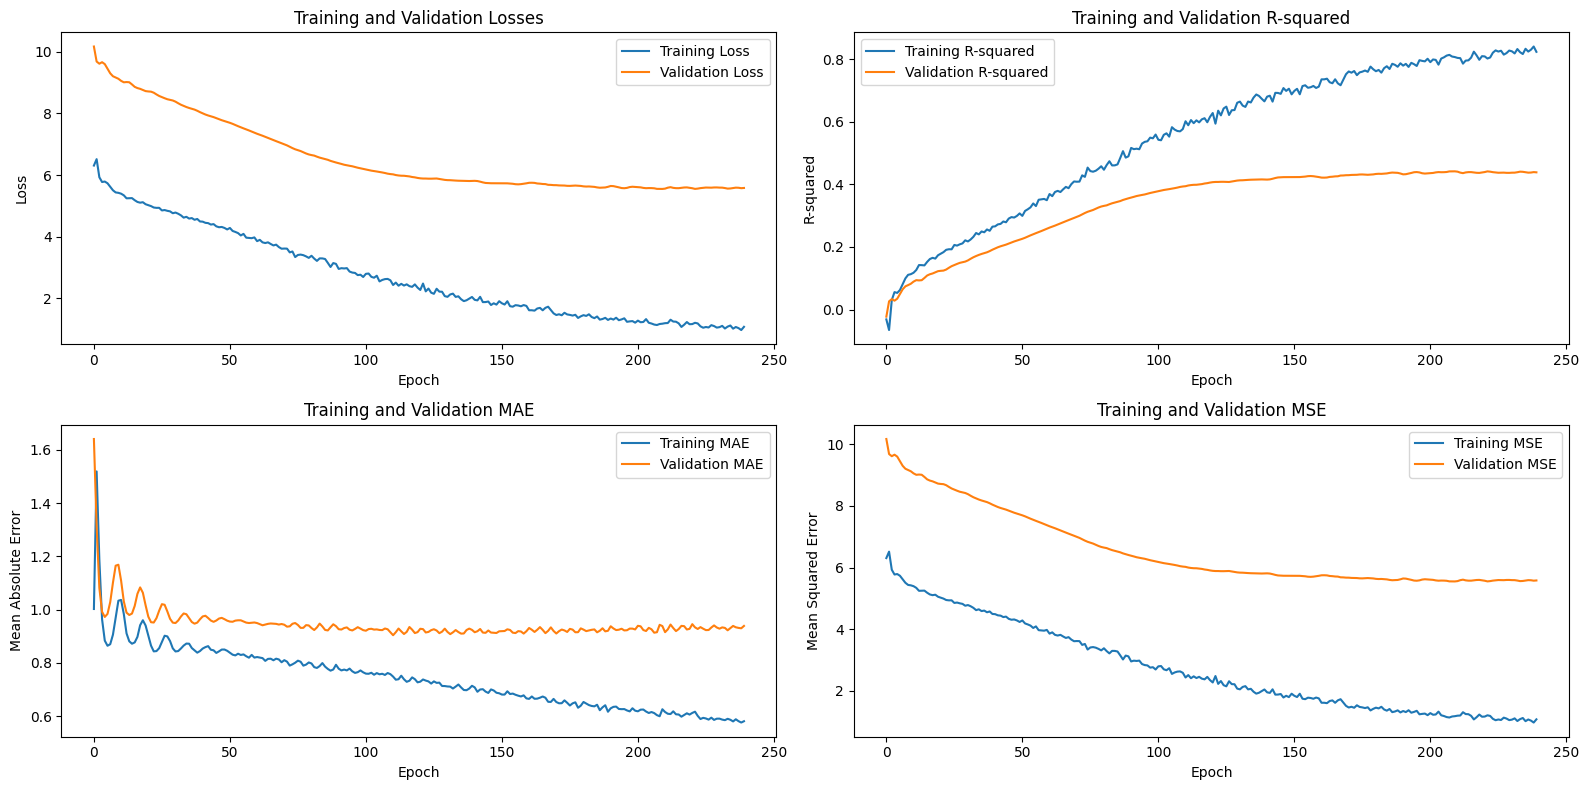

Test R-squared: 0.37232217306768634, Test MAE: 63.407344818115234, Test MSE: 19783.6640625, Avg Test Residual: -2.0679056644439697


In [ ]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_ROME.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_ROME.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_ROME.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')

extra reporting metrics


Test Loss: 3.071967840194702, Test R-squared: 0.37232217306768634, Test MAE: 63.407344818115234, Test MSE: 19783.6640625


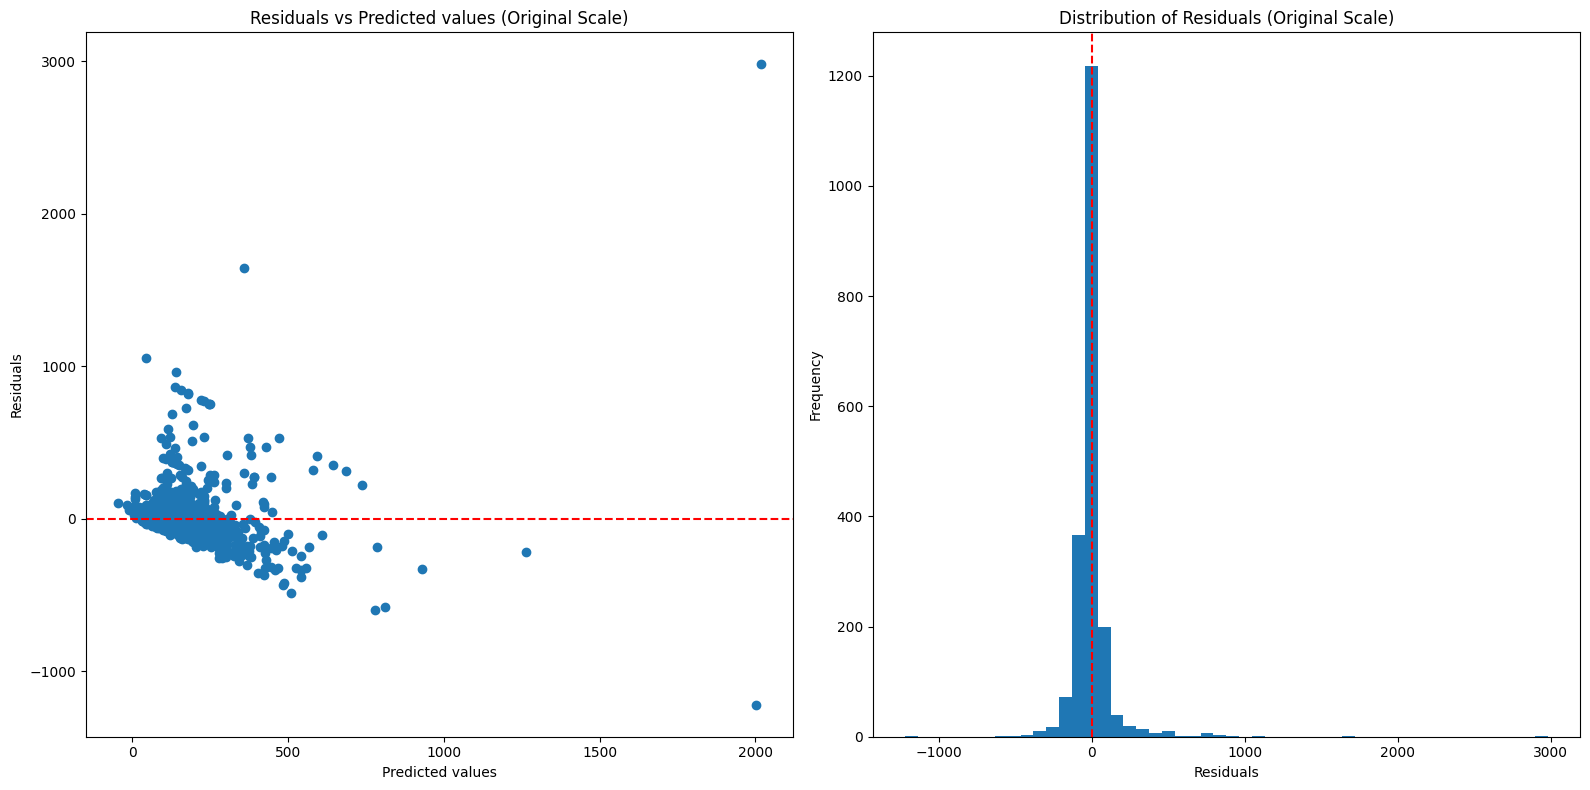

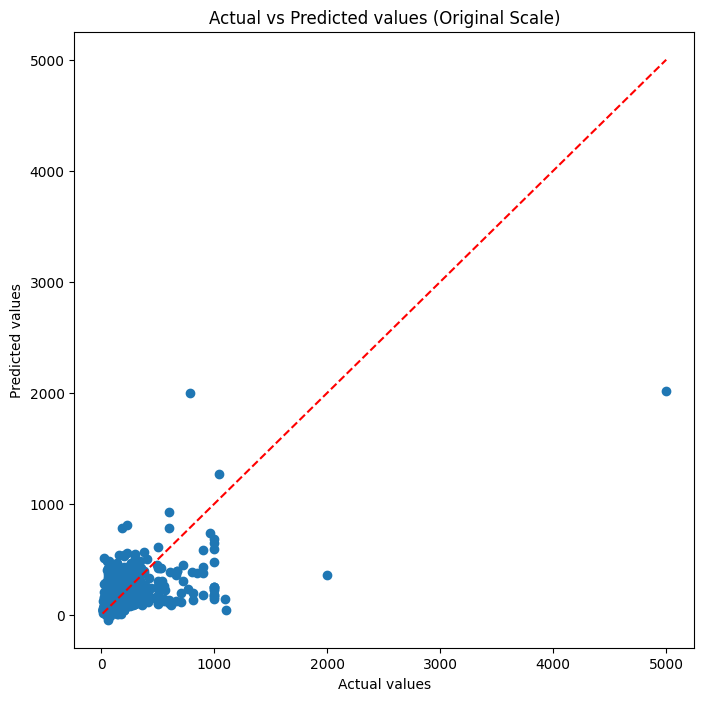

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

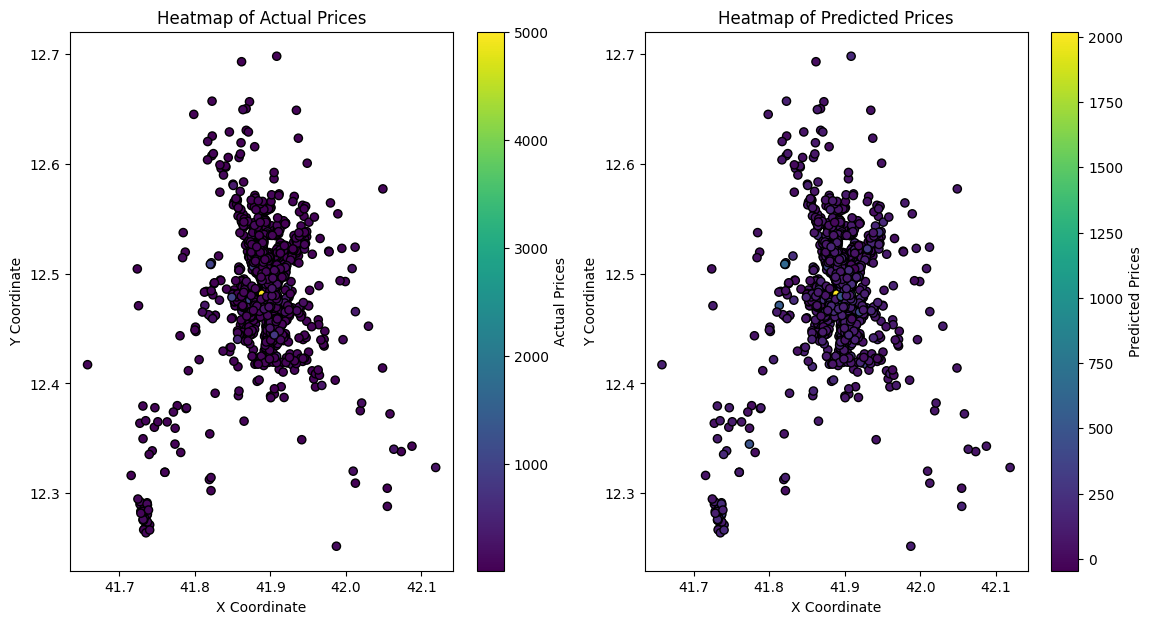

In [ ]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


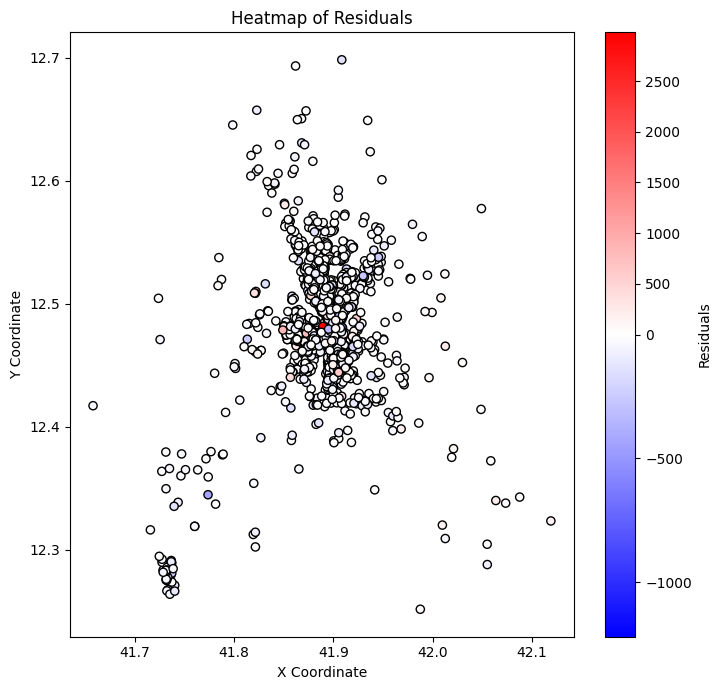

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


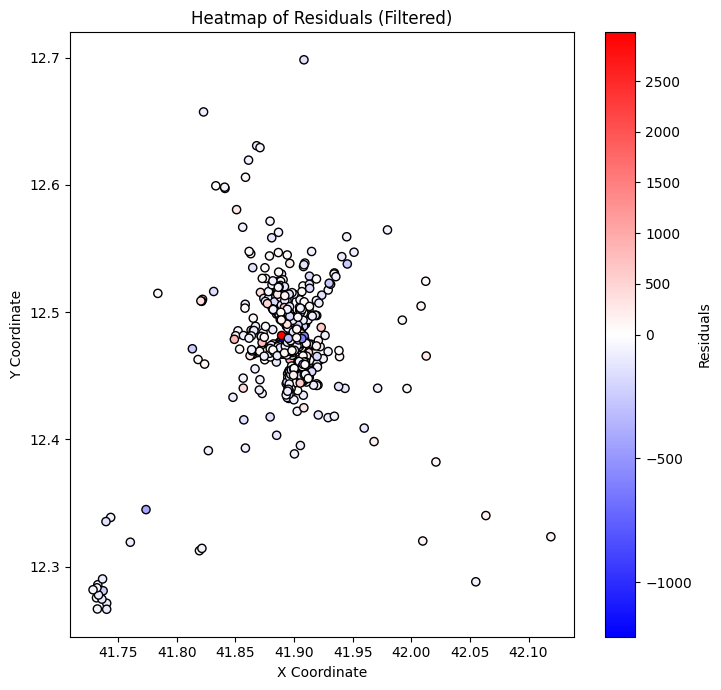

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


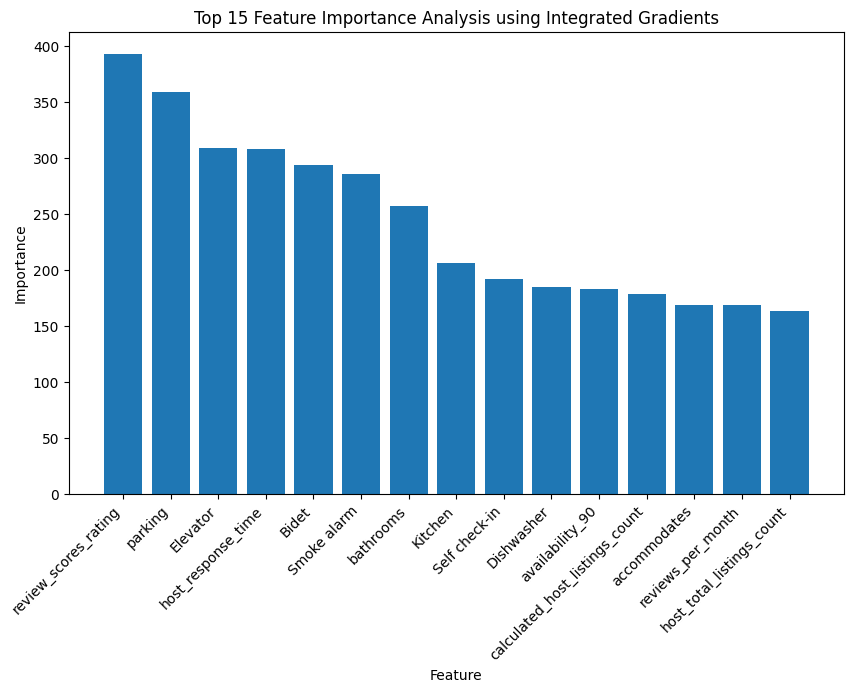

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


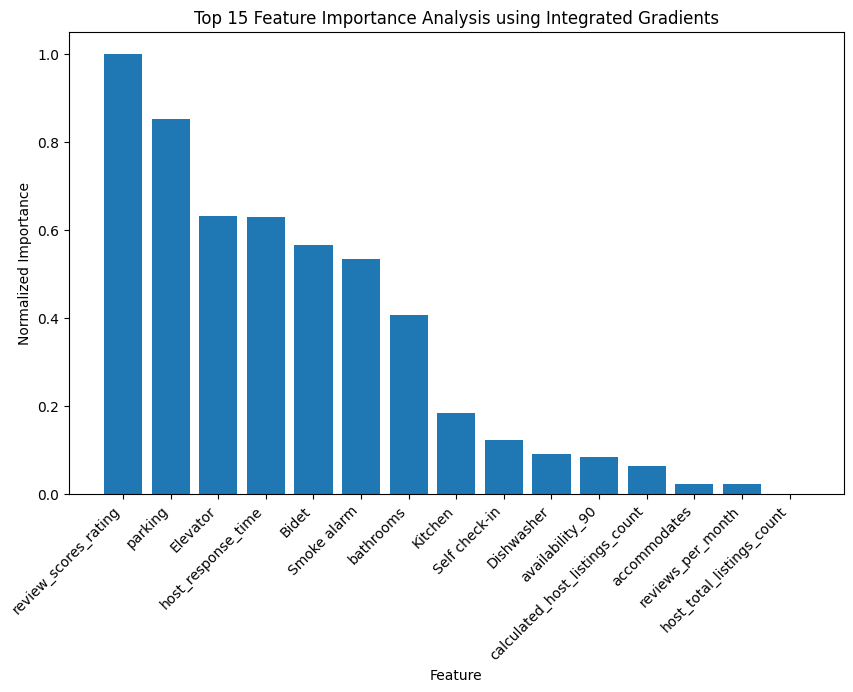

Top 15 Feature Importances (Normalized):
review_scores_rating: 1.0000
parking: 0.8511
Elevator: 0.6316
host_response_time: 0.6292
Bidet: 0.5653
Smoke alarm: 0.5324
bathrooms: 0.4071
Kitchen: 0.1831
Self check-in: 0.1221
Dishwasher: 0.0903
availability_90: 0.0834
calculated_host_listings_count: 0.0626
accommodates: 0.0215
reviews_per_month: 0.0210
host_total_listings_count: 0.0000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")